In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import nltk
import igraph
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jasper\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# Load the comments
df = pd.read_pickle('all_comments.pkl')

In [ ]:
# assign sentiment scores for all comments
vader = SentimentIntensityAnalyzer()

i = 0
scores = []

for sent in df['body']:
    print('\r{0}/{1}'.format(i, len(df)), end='', flush=True)
    i += 1
    
    score = vader.polarity_scores(sent)
        
    scores.append(score)

compound_scores = [score['compound'] for score in scores]
df['sentiment'] = compound_scores

df.to_pickle('comments_sentiment.pkl')

In [3]:
# If we have already done the above
df = pd.read_pickle('comments_sentiment.pkl')

In [6]:
# Helper for cleaning of the two networks
def remove_comments(df, comments):
    tmp = df
    # List of comments scheduled for removal
    ids = list(tmp['id'][comments])
    
    while len(ids) > 0:
        id = ids.pop(0)
        
        # Find all IDs that have this ID as parent and schedule them for removal
        ids += list(tmp['id'][tmp['parent_id'] == id])
        
        # Remove this id
        tmp = tmp[tmp['id'] != id]
        
    return tmp

In [8]:
df_clean = df
df_social = df

In [9]:
# link parent_id to their authors
df_social_nx = pd.merge(df_social, df_social.filter(['author', 'id']), left_on = 'parent_id', right_on = 'id', how = 'left')

# Get the submissions and add them to the mix
df_sub = pd.read_pickle('submissions.pkl')
df_social_nx = pd.merge(df_social_nx, df_sub[df_sub['author'] != 'PoliticsModeratorBot'].filter(['author', 'id']), left_on = 'parent_id', right_on = 'id', how = 'left')
df_social_nx = df_social_nx.filter(['author_x', 'author_y', 'author'])

# Merge in submission author when comment author is NA
df_social_nx['author_y'][pd.isna(df_social_nx['author_y'])] = df_social_nx['author'][pd.isna(df_social_nx['author_y'])]

In [10]:
# Construct graph
social_g = nx.DiGraph()

df_social_nx[~pd.isna(df_social_nx['author_y'])].apply(lambda row: social_g.add_edge(row['author_x'], row['author_y']), axis = 1)
social_g.remove_nodes_from(['AutoModerator', '[deleted]', 'PoliticsModeratorBot'])
print(len(social_g.nodes))


182732


In [11]:
print("Number of nodes: ", len(social_g.nodes))
print("Number of edges: ", len(social_g.edges))

Number of nodes:  182732
Number of edges:  630883


In [12]:
components = [len(c) for c in sorted(nx.weakly_connected_components(social_g), key=len, reverse=True)]
print(components[:20])

components = [len(c) for c in sorted(nx.strongly_connected_components(social_g), key=len, reverse=True)]
print(components[:20])

[181647, 9, 7, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3]
[85246, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Number of nodes:  182732
Number of edges:  84881
100 biggest connected components:  [56053, 12, 10, 9, 9, 9, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Total number of components:  120629
Number of singleton components:  116007


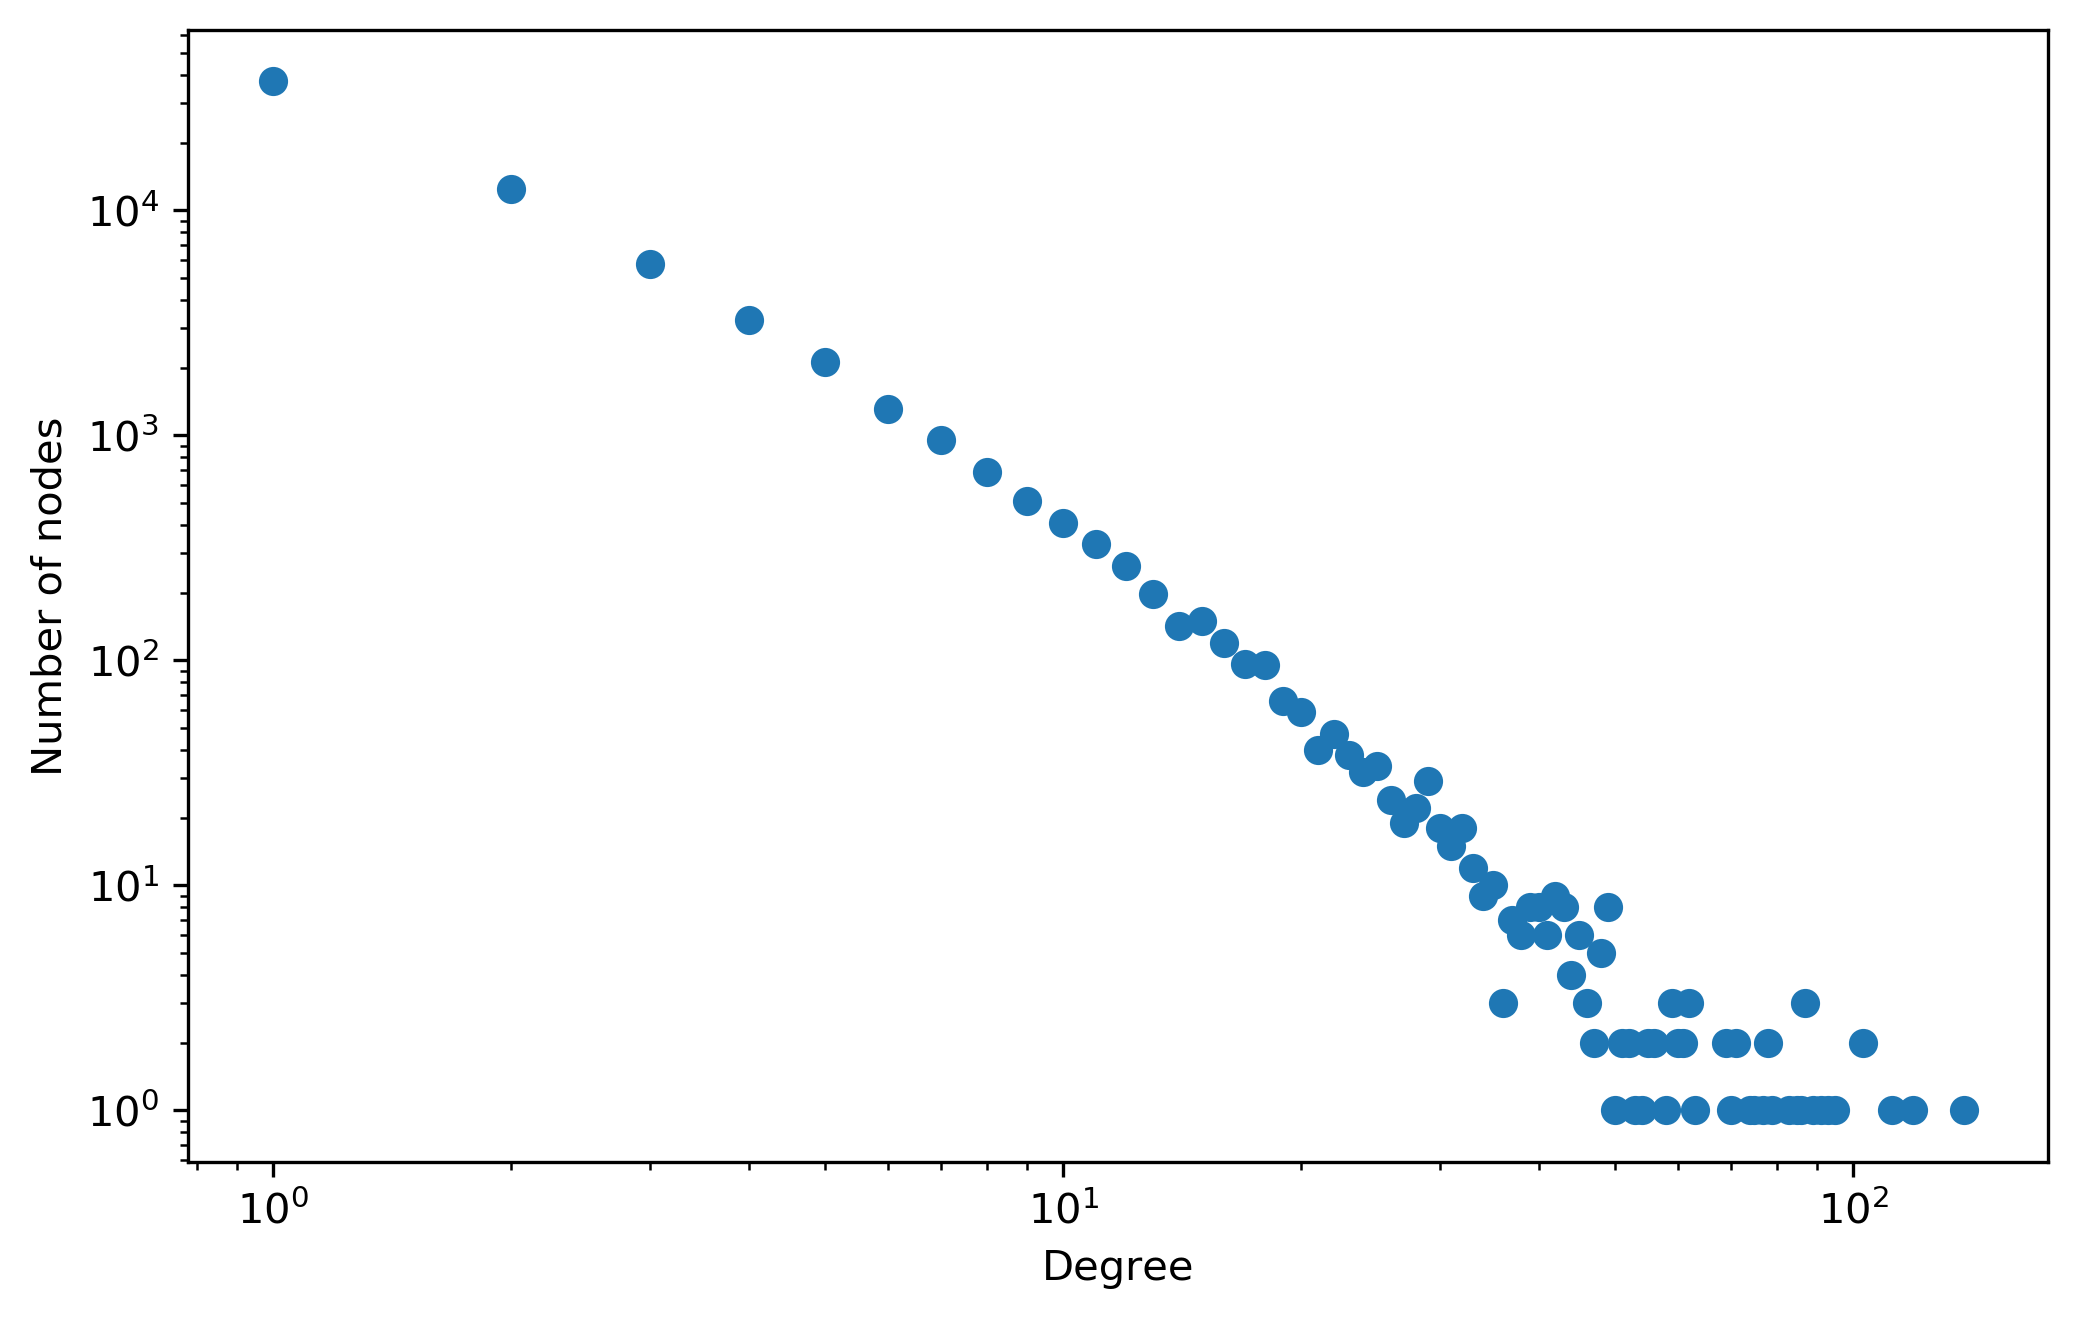

In [13]:
# Construct an undirected graph, only keeping nodes that have back and forth communication
u_social_g = social_g.to_undirected(reciprocal = True)
degrees = [d for n, d in u_social_g.degree()]

points = [degrees.count(i) for i in range(1, max(degrees) + 1)]
on_off = [count != 0 for count in points]

figure(num=None, figsize=(8, 5), dpi=300)

plt.scatter(pd.Series(range(1, max(degrees) + 1))[on_off], pd.Series(points)[on_off])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')

print("Number of nodes: ", len(u_social_g.nodes))
print("Number of edges: ", len(u_social_g.edges))

components = [len(c) for c in sorted(nx.connected_components(u_social_g), key=len, reverse=True)]
print('100 biggest connected components: ', components[:100])
print('Total number of components: ', len(components))
print('Number of singleton components: ', sum([c for c in components if c == 1]))

In [14]:
biggest_component = max([c for c in sorted(nx.connected_components(u_social_g), key=len, reverse=True)])
component = u_social_g.subgraph(biggest_component)

In [15]:
nodes = pd.Series(list(component.nodes()))

dists = []
for i in range(10000):
    sample_nodes = list(nodes.sample(2))
    dists.append(nx.shortest_path_length(component, sample_nodes[0], sample_nodes[1]))
    
print("Average path length: %s +- %s" % (np.mean(dists), np.std(dists) / np.sqrt(len(dists))))


Average path length: 7.3905 +- 0.015286627325868845


54831


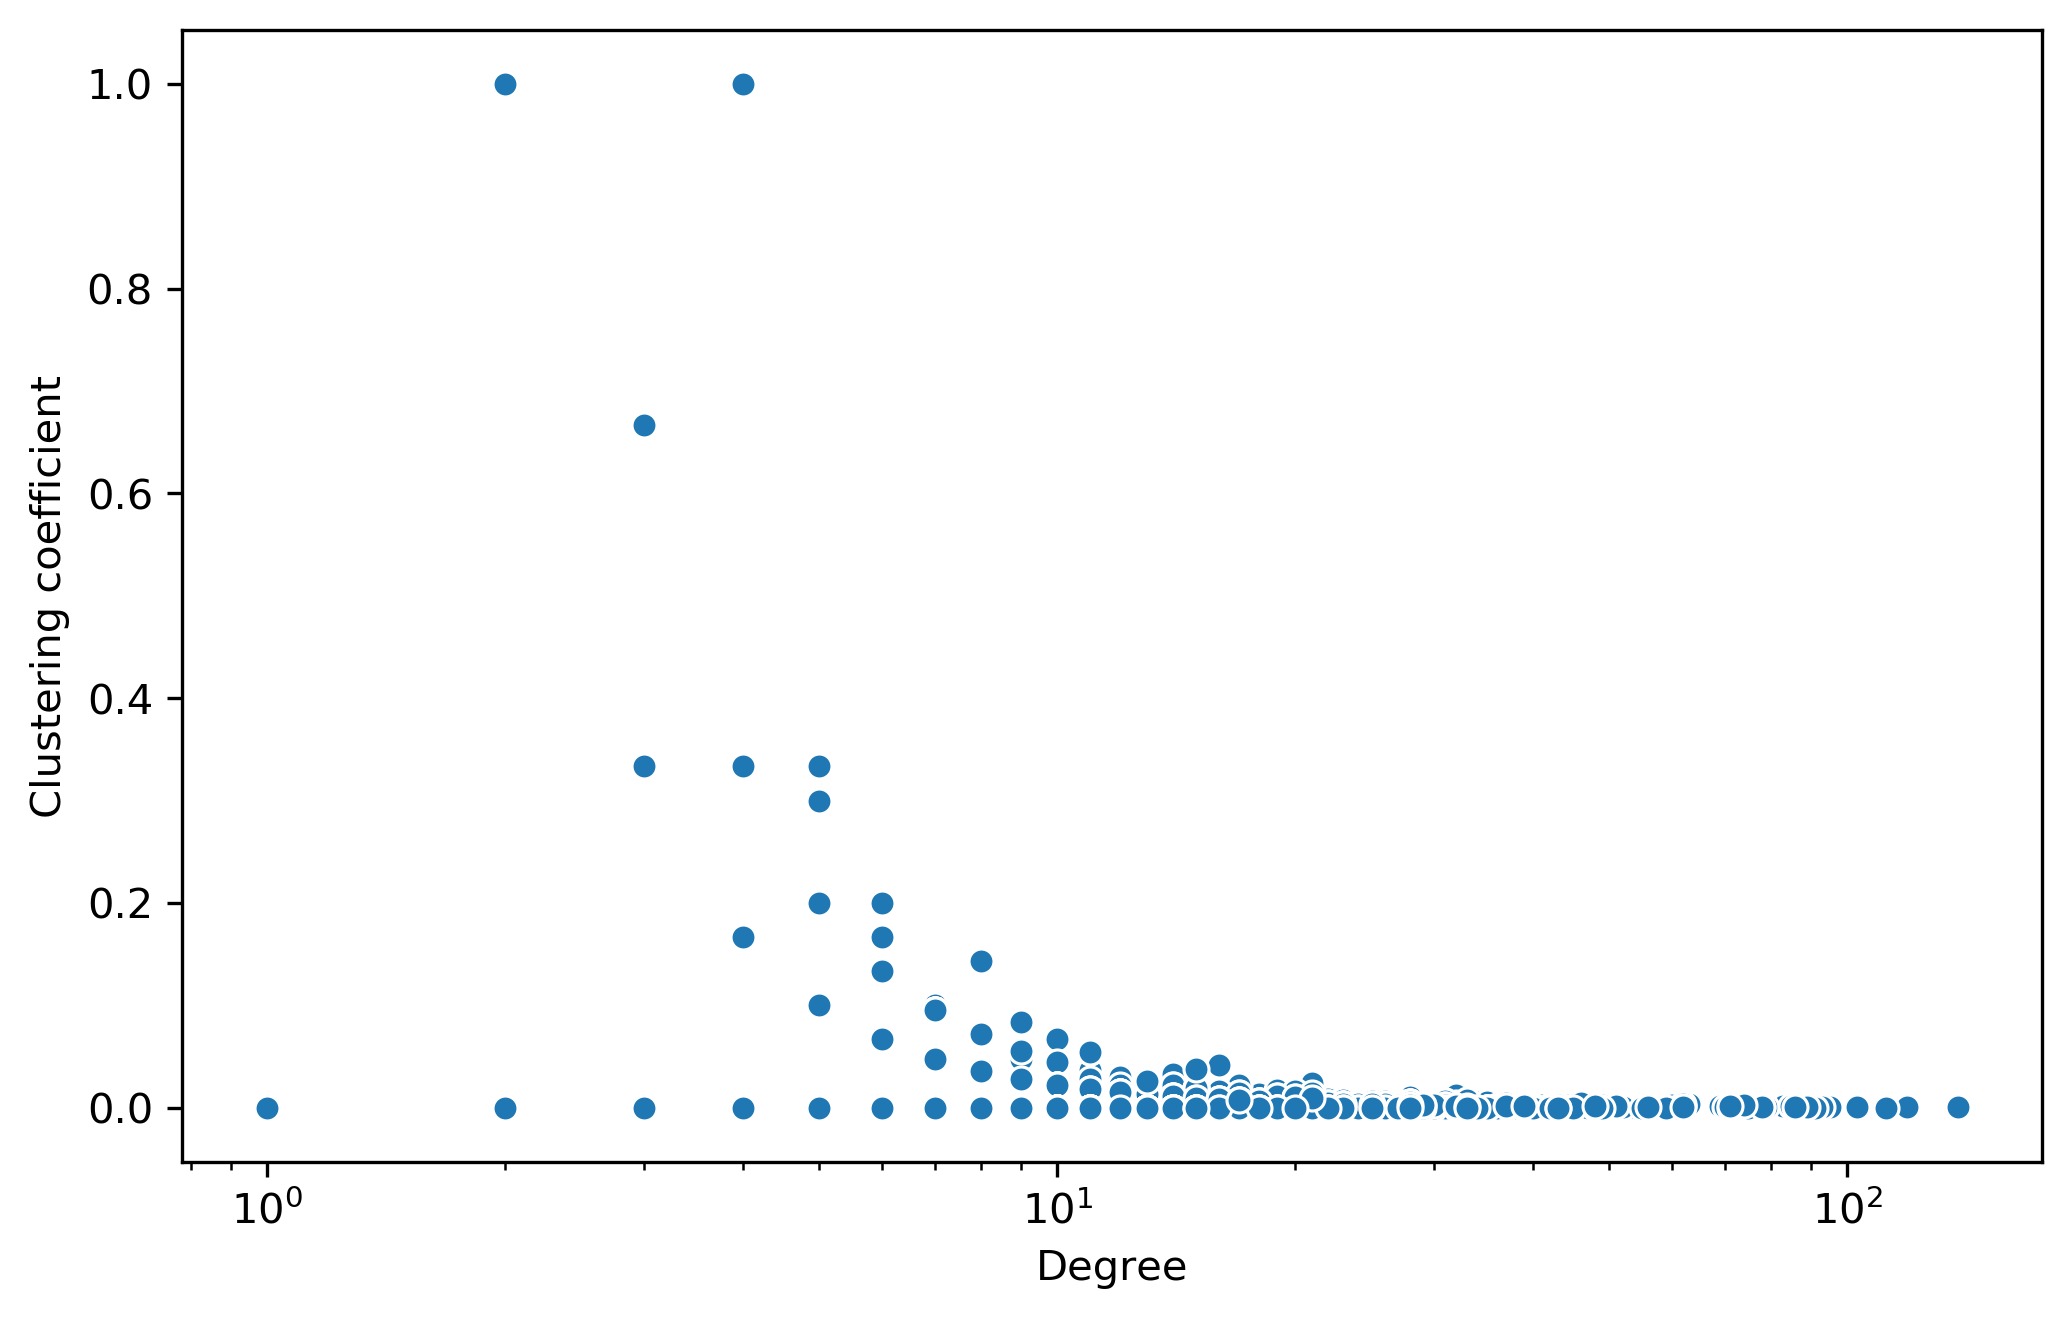

In [16]:
data = []
for node in component.nodes:
    data.append([component.degree(node), nx.clustering(component, node)])
    
data = np.array(data)

figure(num=None, figsize=(8, 5), dpi=300)
sns.scatterplot(data[:, 0], data[:, 1])
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Clustering coefficient')

print(sum(data[:, 1] == 0))

In [17]:
nx.average_clustering(component)

0.0041838670462886534

In [18]:
from networkx.algorithms.approximation.clique import max_clique, large_clique_size
print("Max clique size: ", large_clique_size(component))

Max clique size:  4


[('Enjolras55', 138), ('Usernamesareoutdated', 119), ('sandwooder', 112), ('Diarygirl', 103), ('shizzle_mcbobblehead', 103)]
True
True
True
True
True


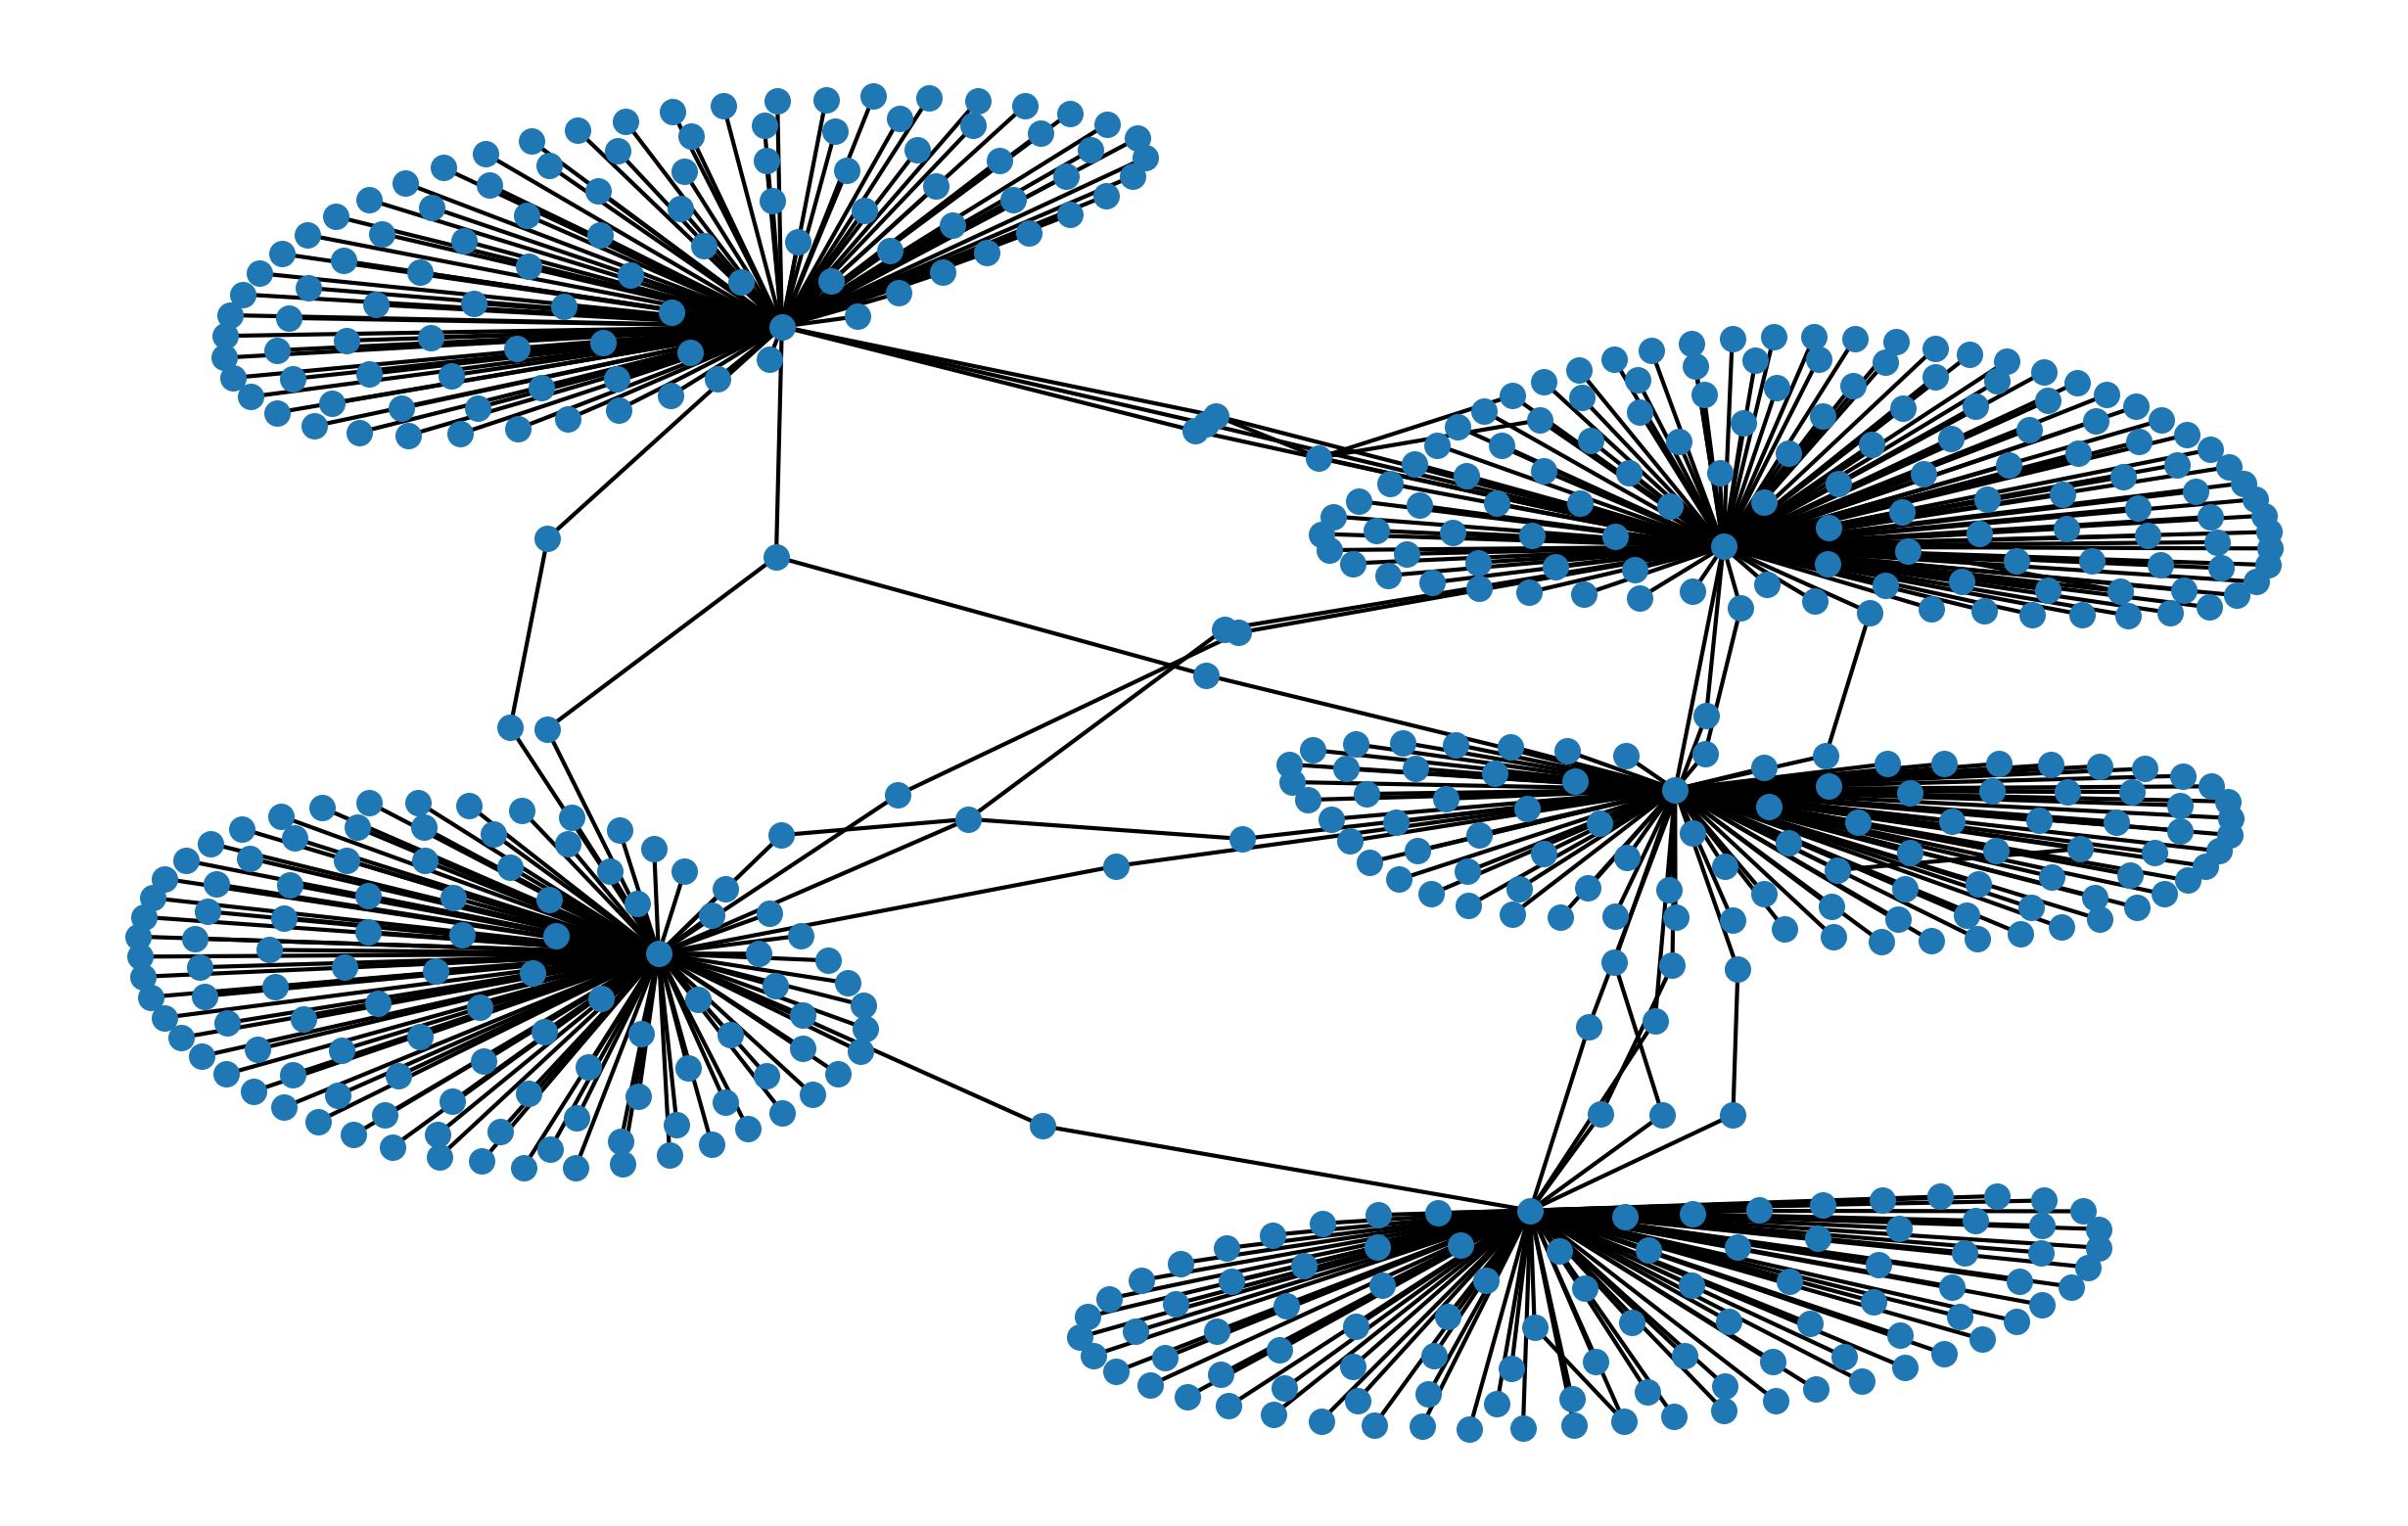

In [19]:
best_nodes = sorted(component.degree(), key = lambda deg: deg[1], reverse = True)[:5]

nodelist = []
print(best_nodes)
for node, degree in best_nodes:
    nodelist.append(node)
    for child in component.neighbors(node):
        nodelist.append(child)
   
figure(num=None, figsize=(8, 5), dpi=300)

subgraph = component.subgraph(nodelist)
nx.draw_kamada_kawai(subgraph, node_size = 30)

for node, degree in best_nodes:
    print(node in nodelist)

138
True
True
True
True
True


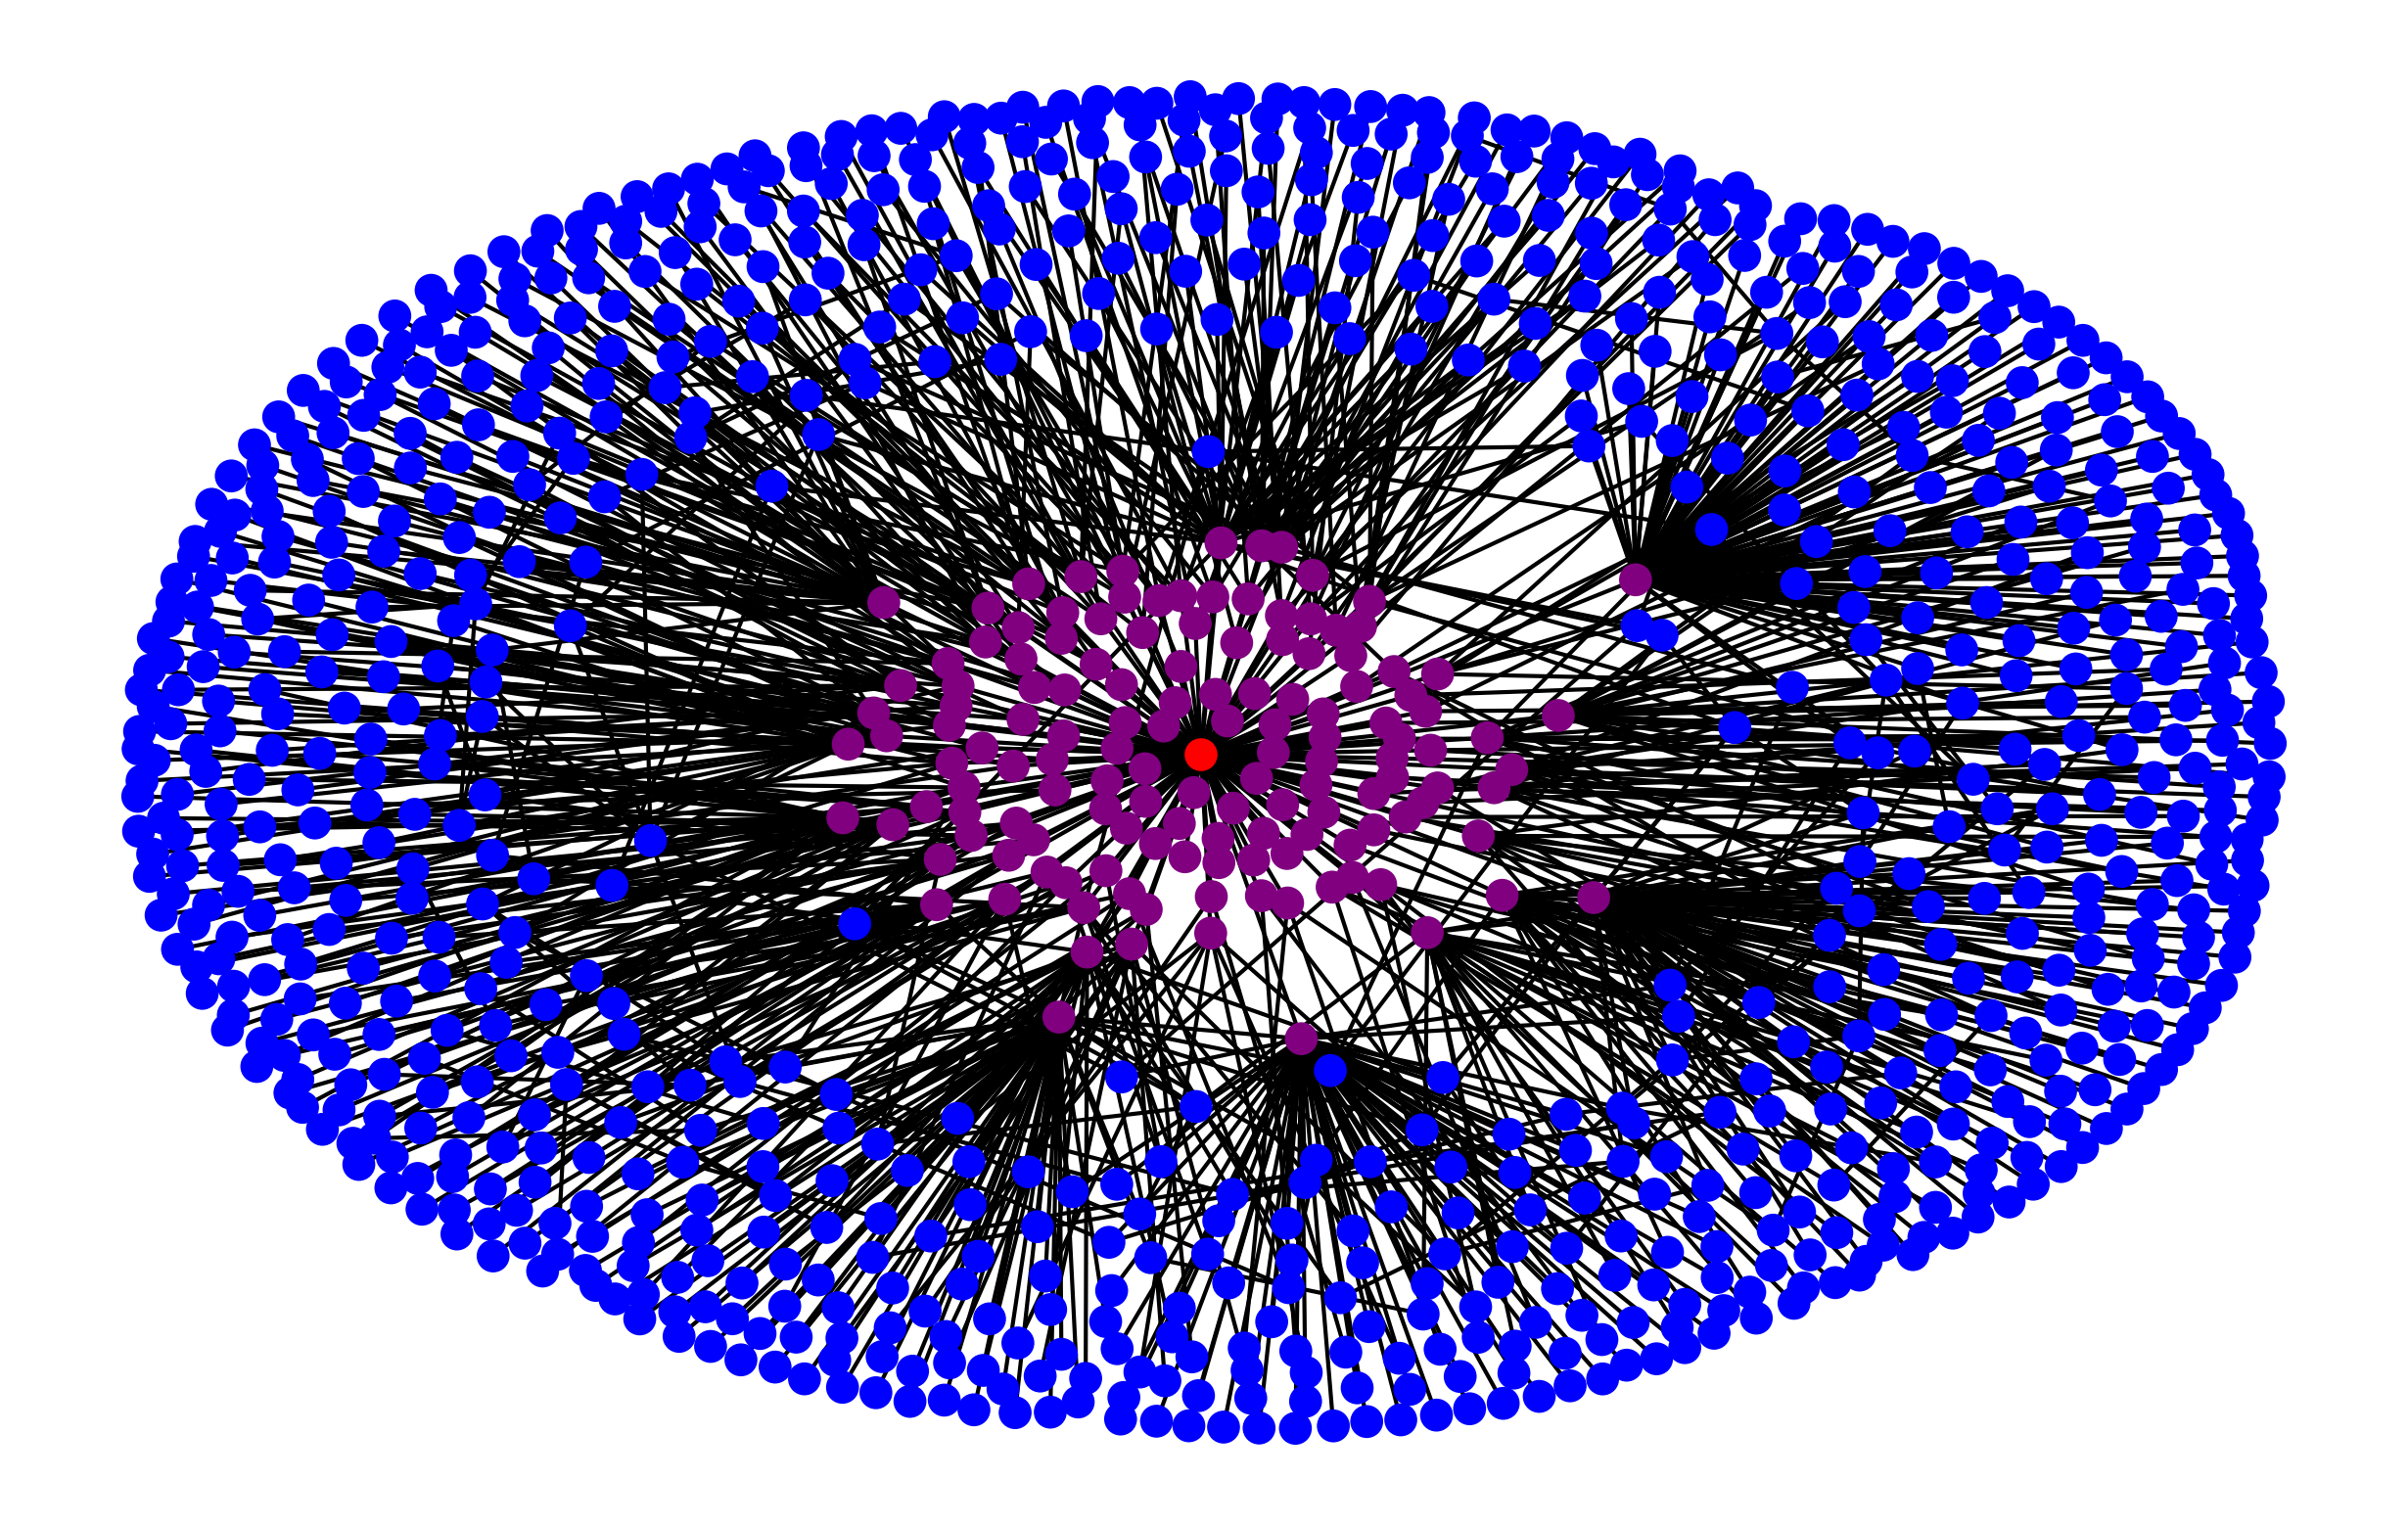

In [20]:
best_node = max(component.degree(), key = lambda deg: deg[1])[0]

to_scan = [best_node]
scanned = []
depth = []
colours = ['red', 'purple', 'blue']

for i in range(3):
    tmp = []
    while len(to_scan) > 0:
        node = to_scan.pop()
        if node not in scanned:
            scanned.append(node)
            depth.append(colours[i])

        for child in component.neighbors(node):
            if child not in scanned:
                tmp.append(child)
            
    to_scan += tmp
    
print(sum([1 for d in depth if d == 'purple']))
   
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 5), dpi=300)

subgraph = component.subgraph(scanned)
nx.draw_kamada_kawai(subgraph, nodelist = scanned, node_size = 50, node_color = depth)

for node, degree in best_nodes:
    print(node in nodelist)

In [21]:
# create post tree
post_ids = df_clean['link_id'].unique()

df_post = df_clean[df_clean['link_id'] == list(post_ids)[0]]

g_post = nx.convert_matrix.from_pandas_edgelist(df_post, source = 'parent_id', target = 'id', create_using = nx.DiGraph)
print(len(g_post.edges))

print(df_sub.id.head())

7023
0    dsgvse
1    dr5ta9
2    ds9hgg
3    ds9jwb
4    dsehwu
Name: id, dtype: object


In [22]:
# Add sentiment to nodes (need to add sentiment for submissions as well)
vader = SentimentIntensityAnalyzer()

for i, row in df_post.iterrows():
    if row.id in g_post.nodes:
        g_post.nodes[row.id]['sent'] = row.sentiment
        g_post.nodes[row.id]['score'] = row.score
       
# Calculate sentiment for submission titles
for i, row in df_sub.iterrows():
    if row.id in g_post.nodes:
        g_post.nodes[row.id]['sent'] = vader.polarity_scores(row.title)['compound']

In [23]:
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import numpy as np

# Makes sure that we're working with a tree, not a forest
def drop_external_trees(tree):
    tmp = tree
    removelist = set(tmp.nodes) - max(nx.weakly_connected_components(tmp), key=len)
    tmp.remove_nodes_from(removelist)
    return tmp

# Calculates sentiment of all descendants
def calculate_sentiment_full(tree, graph):
    tree = drop_external_trees(tree)
    root = [n for n,d in tree.in_degree() if d==0][0]
    
    sents = []
    
    for node in tree:
        if node != root:
            sents.append(graph.nodes[node]['sent'] / 2 ** (nx.shortest_path_length(graph, root, node) - 1))
        
    return sents

# Calculates sentiment of just the node's children
def calculate_sentiment_neigh(tree, graph):
    tree = drop_external_trees(tree)
    root = [n for n,d in tree.in_degree() if d==0][0]
    
    sents = []
    
    for node in tree.neighbors(root):
        sents.append(graph.nodes[node]['sent'])
        
    return sents

# Traverses the subtree of the node, either through its best or through its worst nodes
def calculate_sentiment_depth(tree, graph, calc_max = True):
    tree = drop_external_trees(tree)
    root = [n for n,d in tree.in_degree() if d==0][0]
    
    sents = []
    
    more_nodes = True
    best_node = (root, float('-inf') if calc_max else float('inf'))
    
    while more_nodes:        
        for node in tree.neighbors(best_node[0]):
            score = graph.nodes[node]['score']
            if calc_max and score > best_node[1]:
                best_node = (node, score)
            elif not calc_max and score < best_node[1]:
                best_node = (node, score)
                
        sents.append(graph.nodes[best_node[0]]['sent'] / 2 ** (nx.shortest_path_length(graph, root, best_node[0]) - 1))
        
        best_node = (best_node[0], float('-inf') if calc_max else float('inf'))
        
        if tree.out_degree(best_node[0]) < 2:
            more_nodes = False
            
    return sents
                
    
        
clean_tree = drop_external_trees(g_post)

full_sents = []
neigh_sents = []
depth_sents = []
depth_sents_worst = []

# Analyse all subtrees
for node in clean_tree.nodes:
    subtree = dfs_tree(clean_tree, node)
    if len(subtree.nodes) > 1:
        for sent in [np.mean(calculate_sentiment_neigh(subtree, g_post))]:
            neigh_sents.append({
            'node': node,
            'self_sent': clean_tree.nodes[node]['sent'],
            'child_sent': sent
            })
        for sent in [np.mean(calculate_sentiment_full(subtree, g_post))]:
            full_sents.append({
            'node': node,
            'self_sent': clean_tree.nodes[node]['sent'],
            'child_sent': sent
            })
        if len(subtree.nodes) > 2:
            for sent in [np.mean(calculate_sentiment_depth(subtree, g_post))]:
                depth_sents.append({
                'node': node,
                'self_sent': clean_tree.nodes[node]['sent'],
                'child_sent': sent
                })
            for sent in [np.mean(calculate_sentiment_depth(subtree, g_post, calc_max = False))]:
                depth_sents_worst.append({
                'node': node,
                'self_sent': clean_tree.nodes[node]['sent'],
                'child_sent': sent
                })
        
df_sents = {'full': pd.DataFrame(full_sents), 'neigh': pd.DataFrame(neigh_sents),
             'depth': pd.DataFrame(depth_sents), 'depth_worst': pd.DataFrame(depth_sents_worst)}

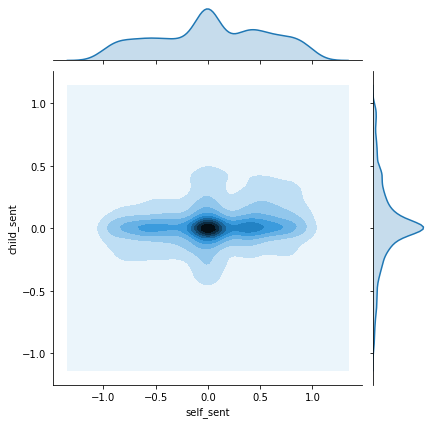

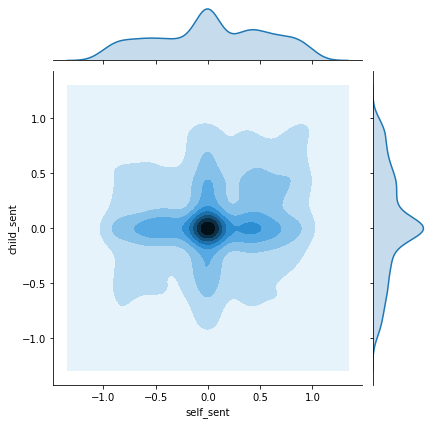

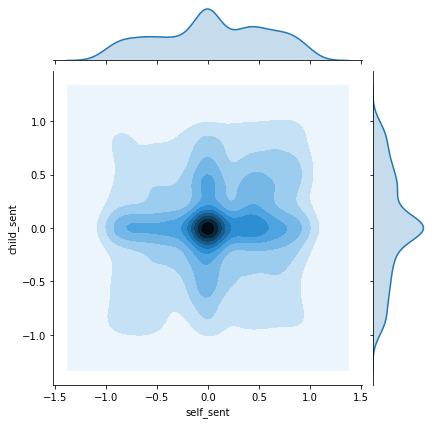

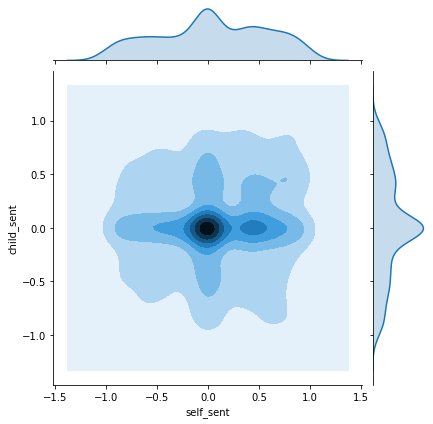

In [24]:
# Plot distplots of parent against children sentiment
for df in ['full', 'neigh', 'depth', 'depth_worst']:
    sns.jointplot(x = 'self_sent', y = 'child_sent', data = df_sents[df], kind = 'kde')
    

In [25]:
# Remove 0 sentiments and add indicator variables for postivity
for df in ['full', 'neigh', 'depth', 'depth_worst']:
    df_sents[df] = df_sents[df][(df_sents[df].self_sent != 0) | (df_sents[df].child_sent != 0)]
    df_sents[df]['self_pos'] = df_sents[df].self_sent > 0
    df_sents[df]['child_pos'] = df_sents[df].child_sent > 0

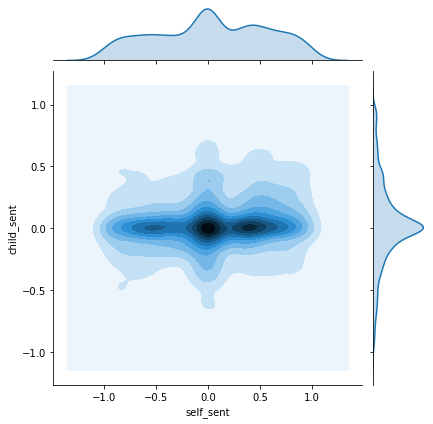

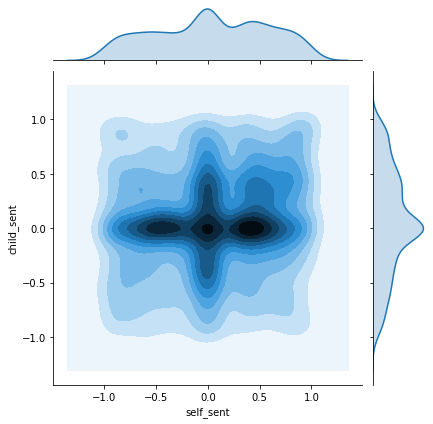

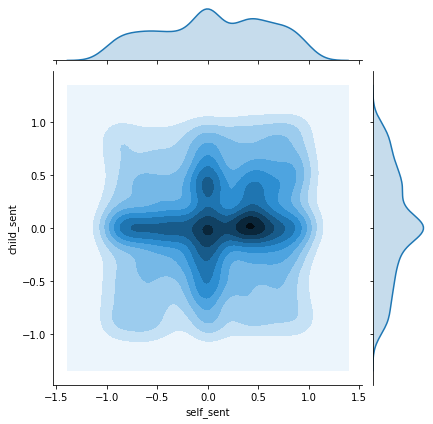

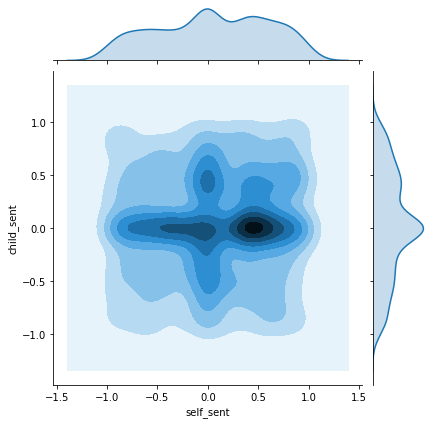

In [26]:
# Plot distplots of parent against children sentiment
for df in ['full', 'neigh', 'depth', 'depth_worst']:
    sns.jointplot(x = 'self_sent', y = 'child_sent', data = df_sents[df], kind = 'kde')

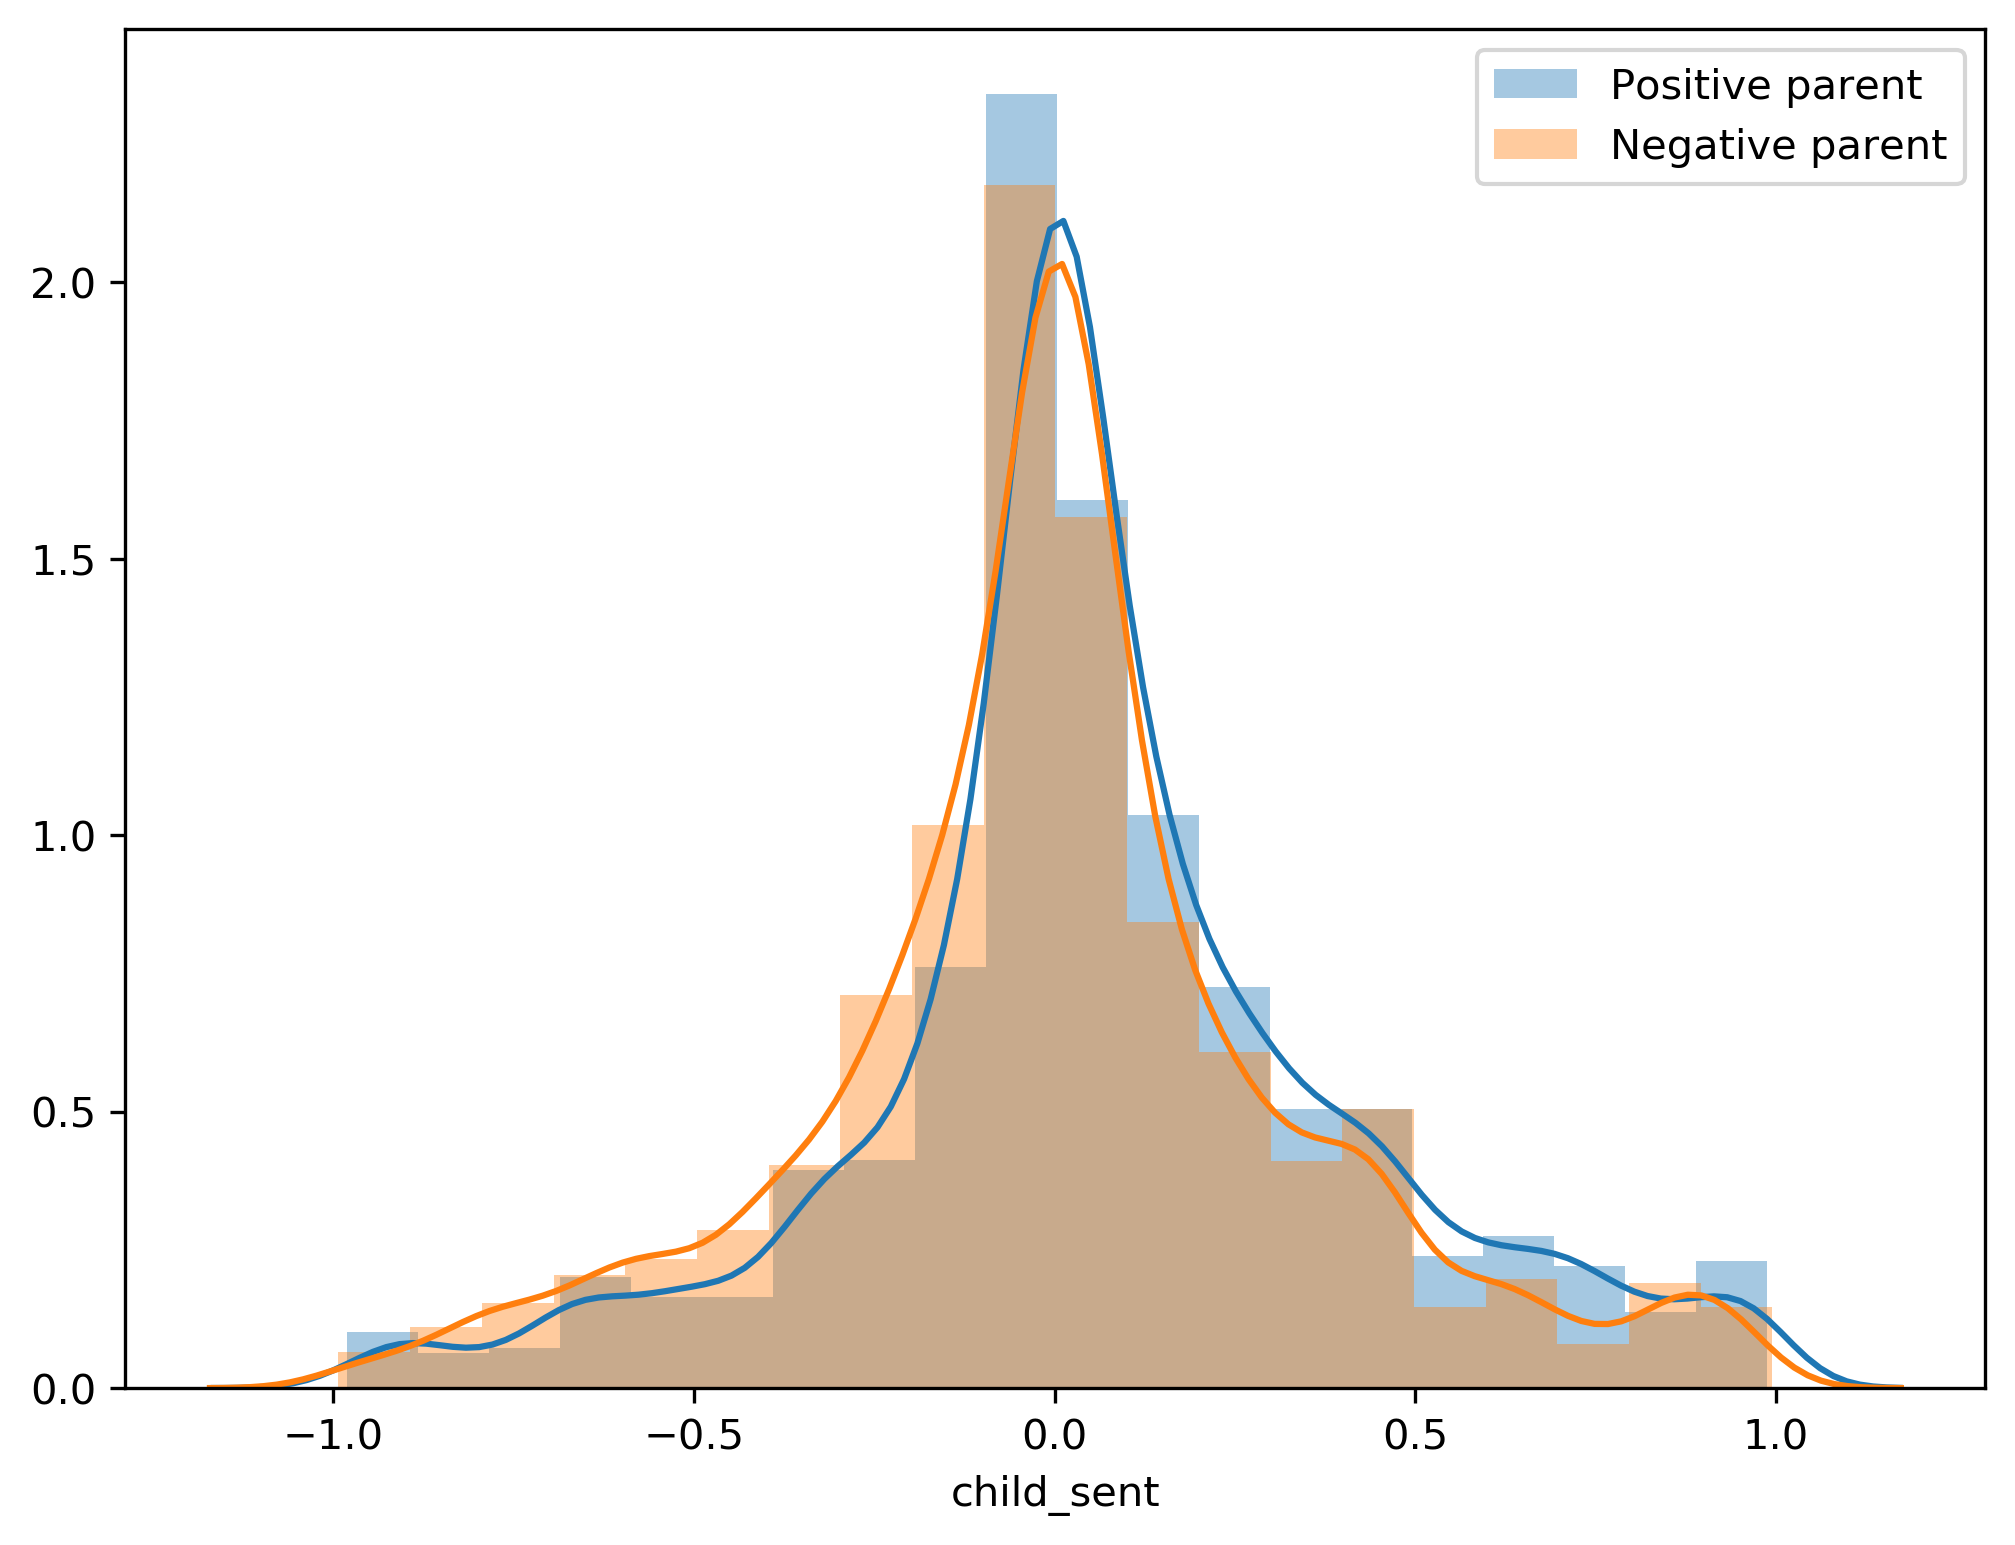

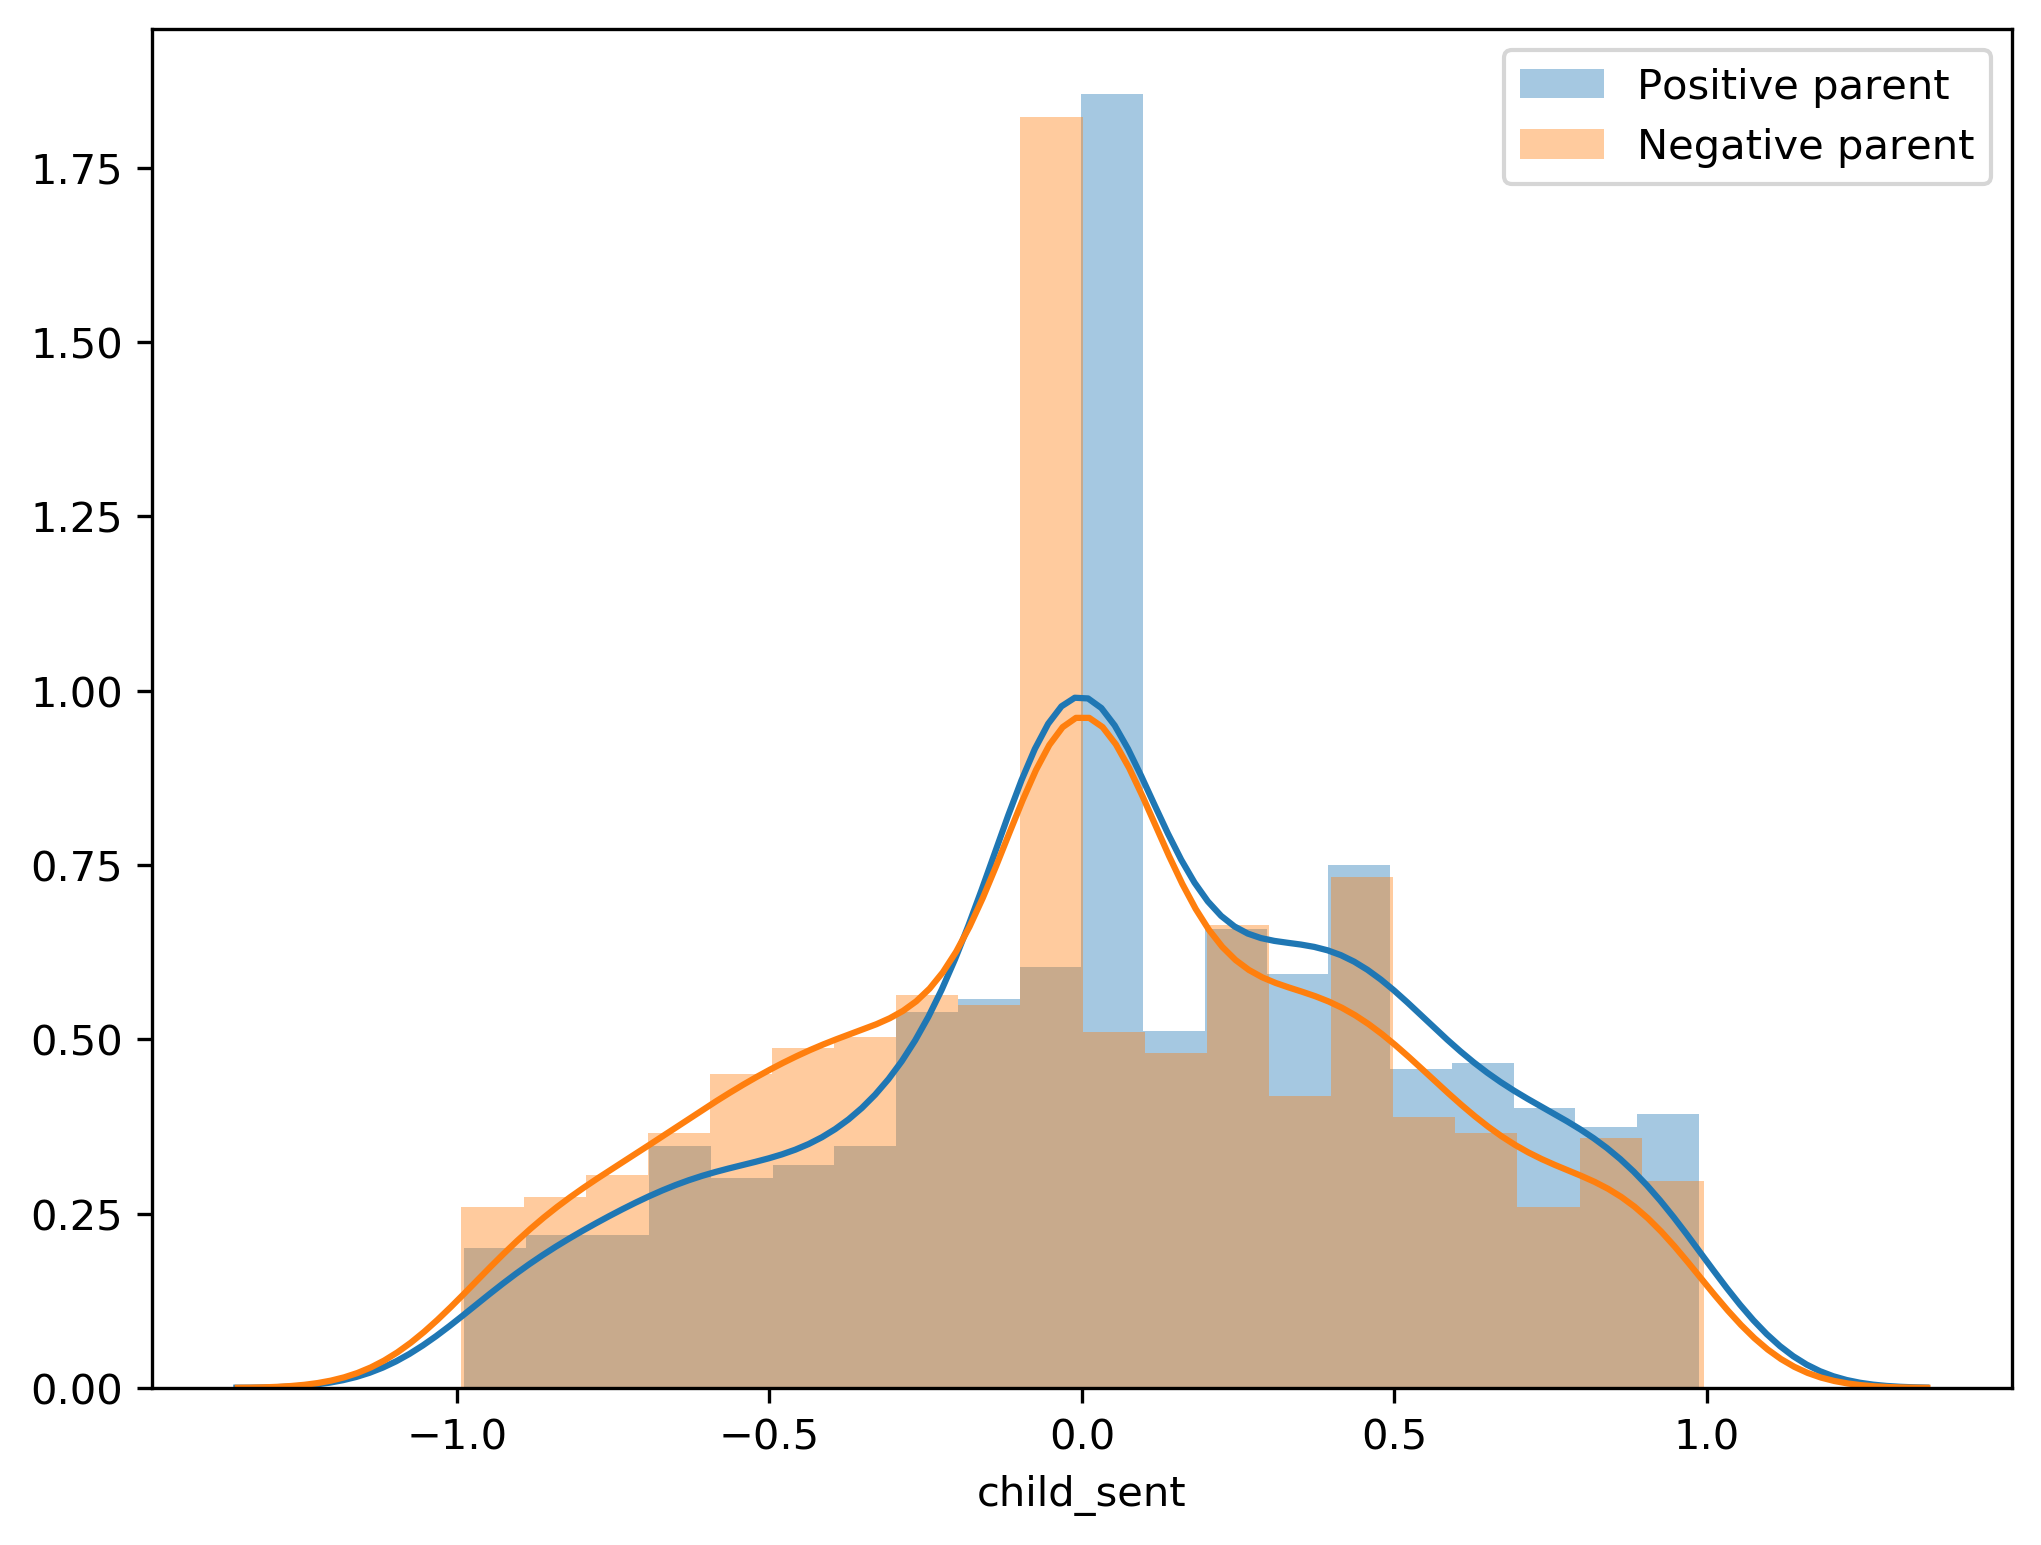

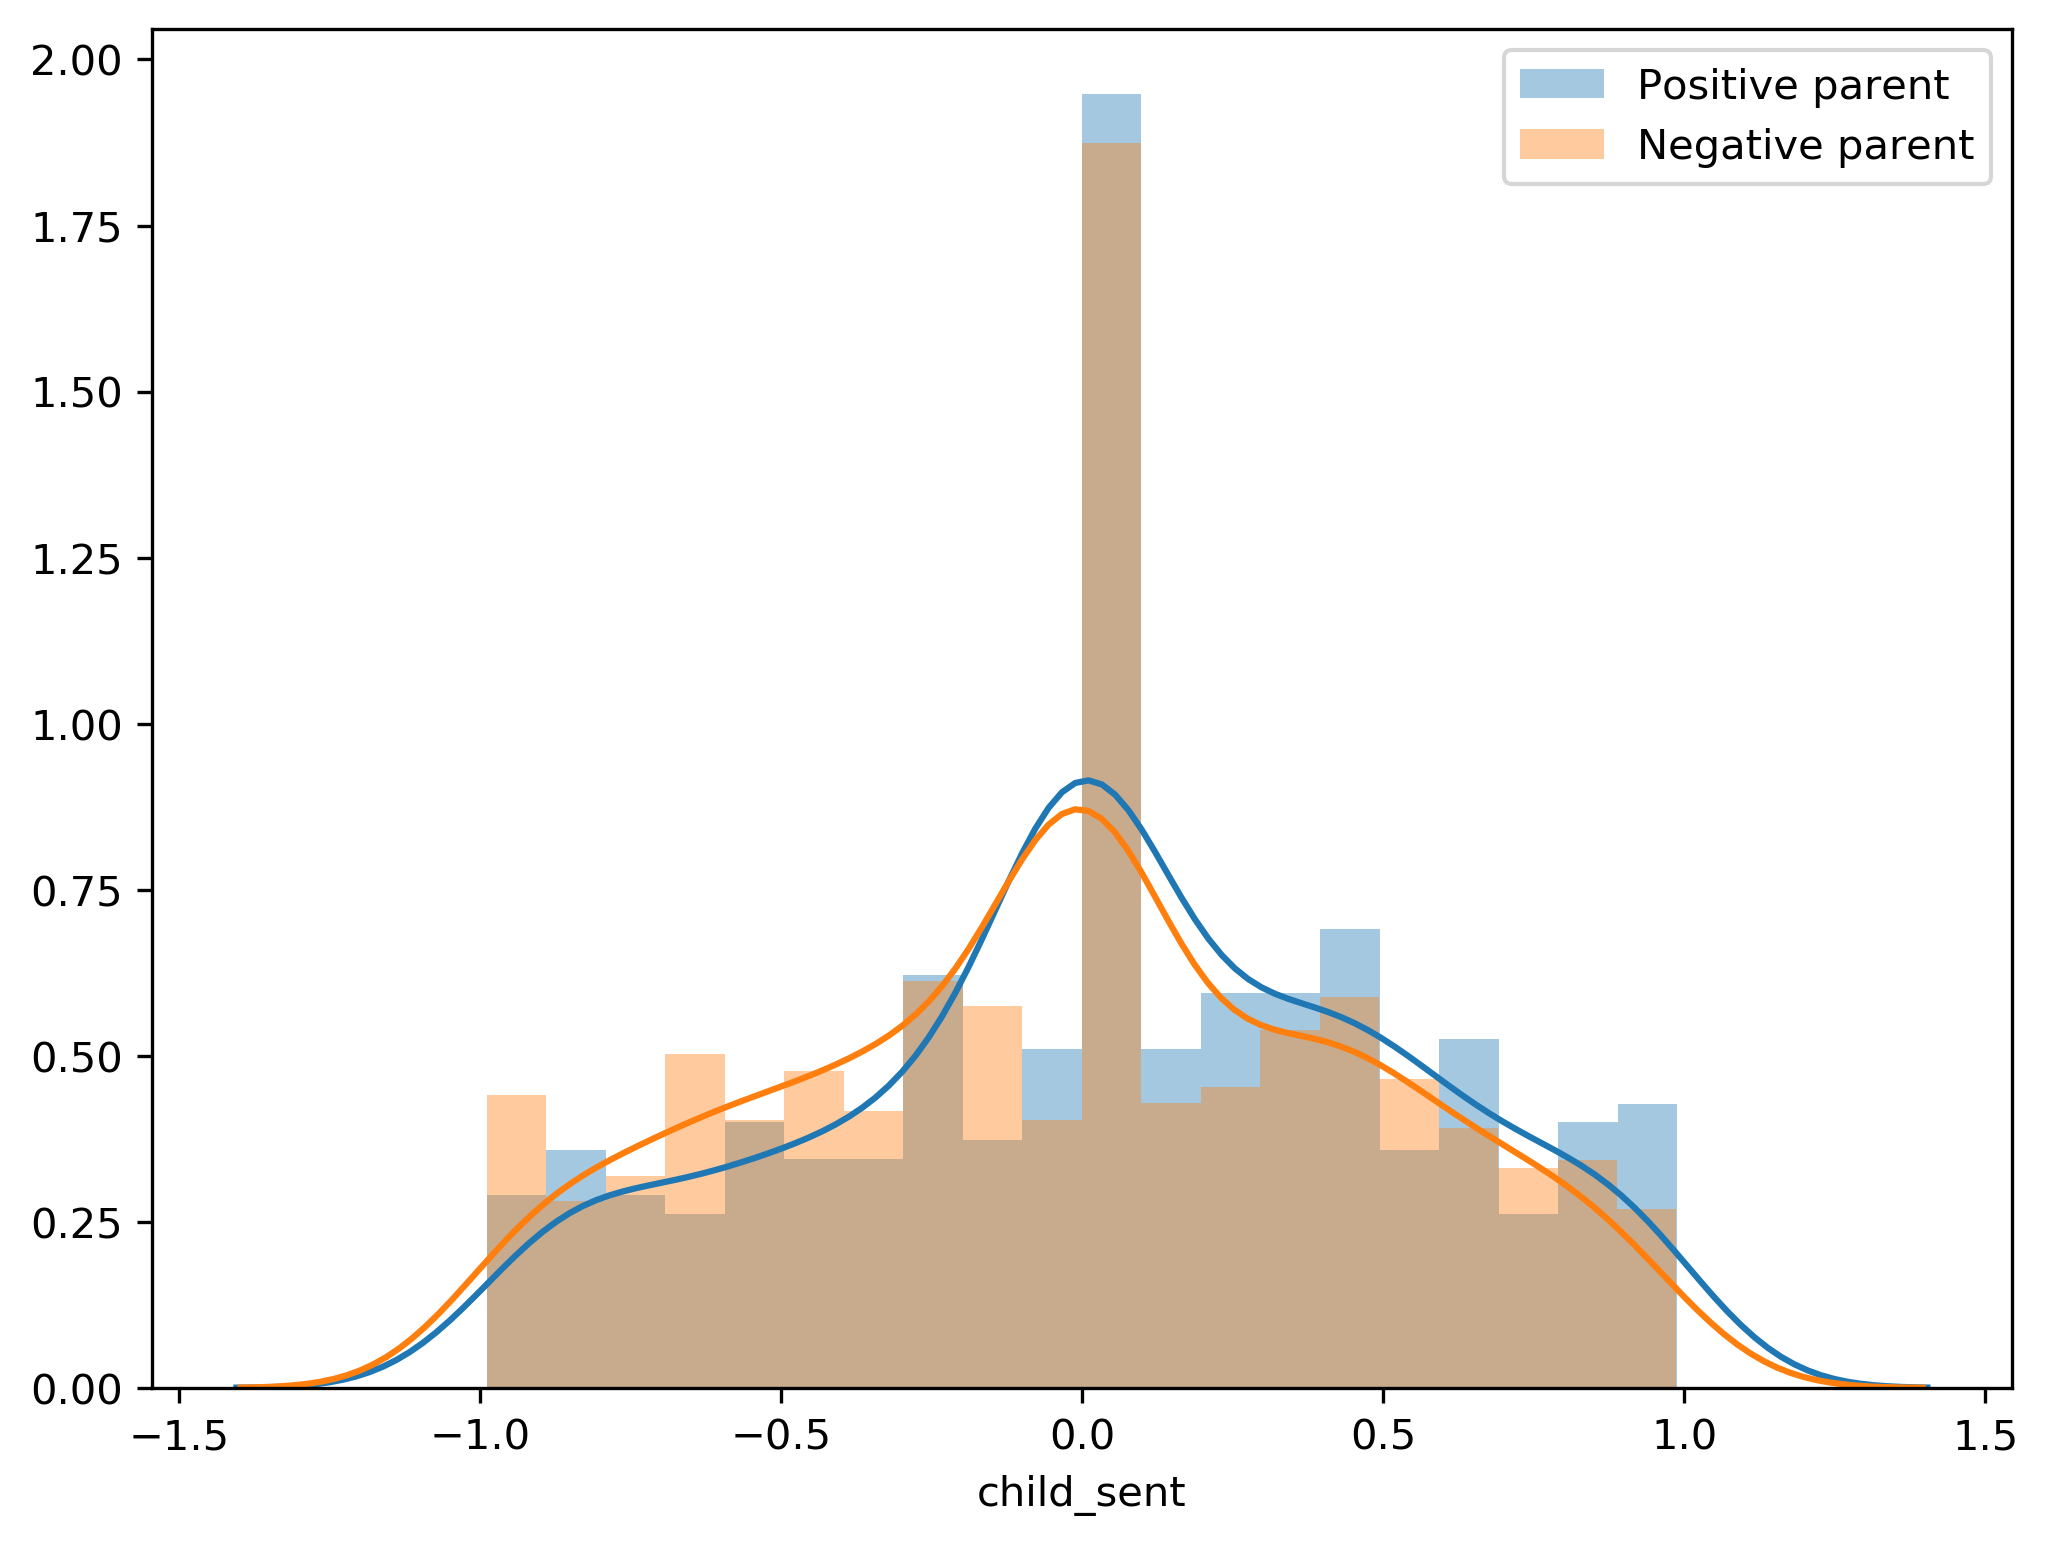

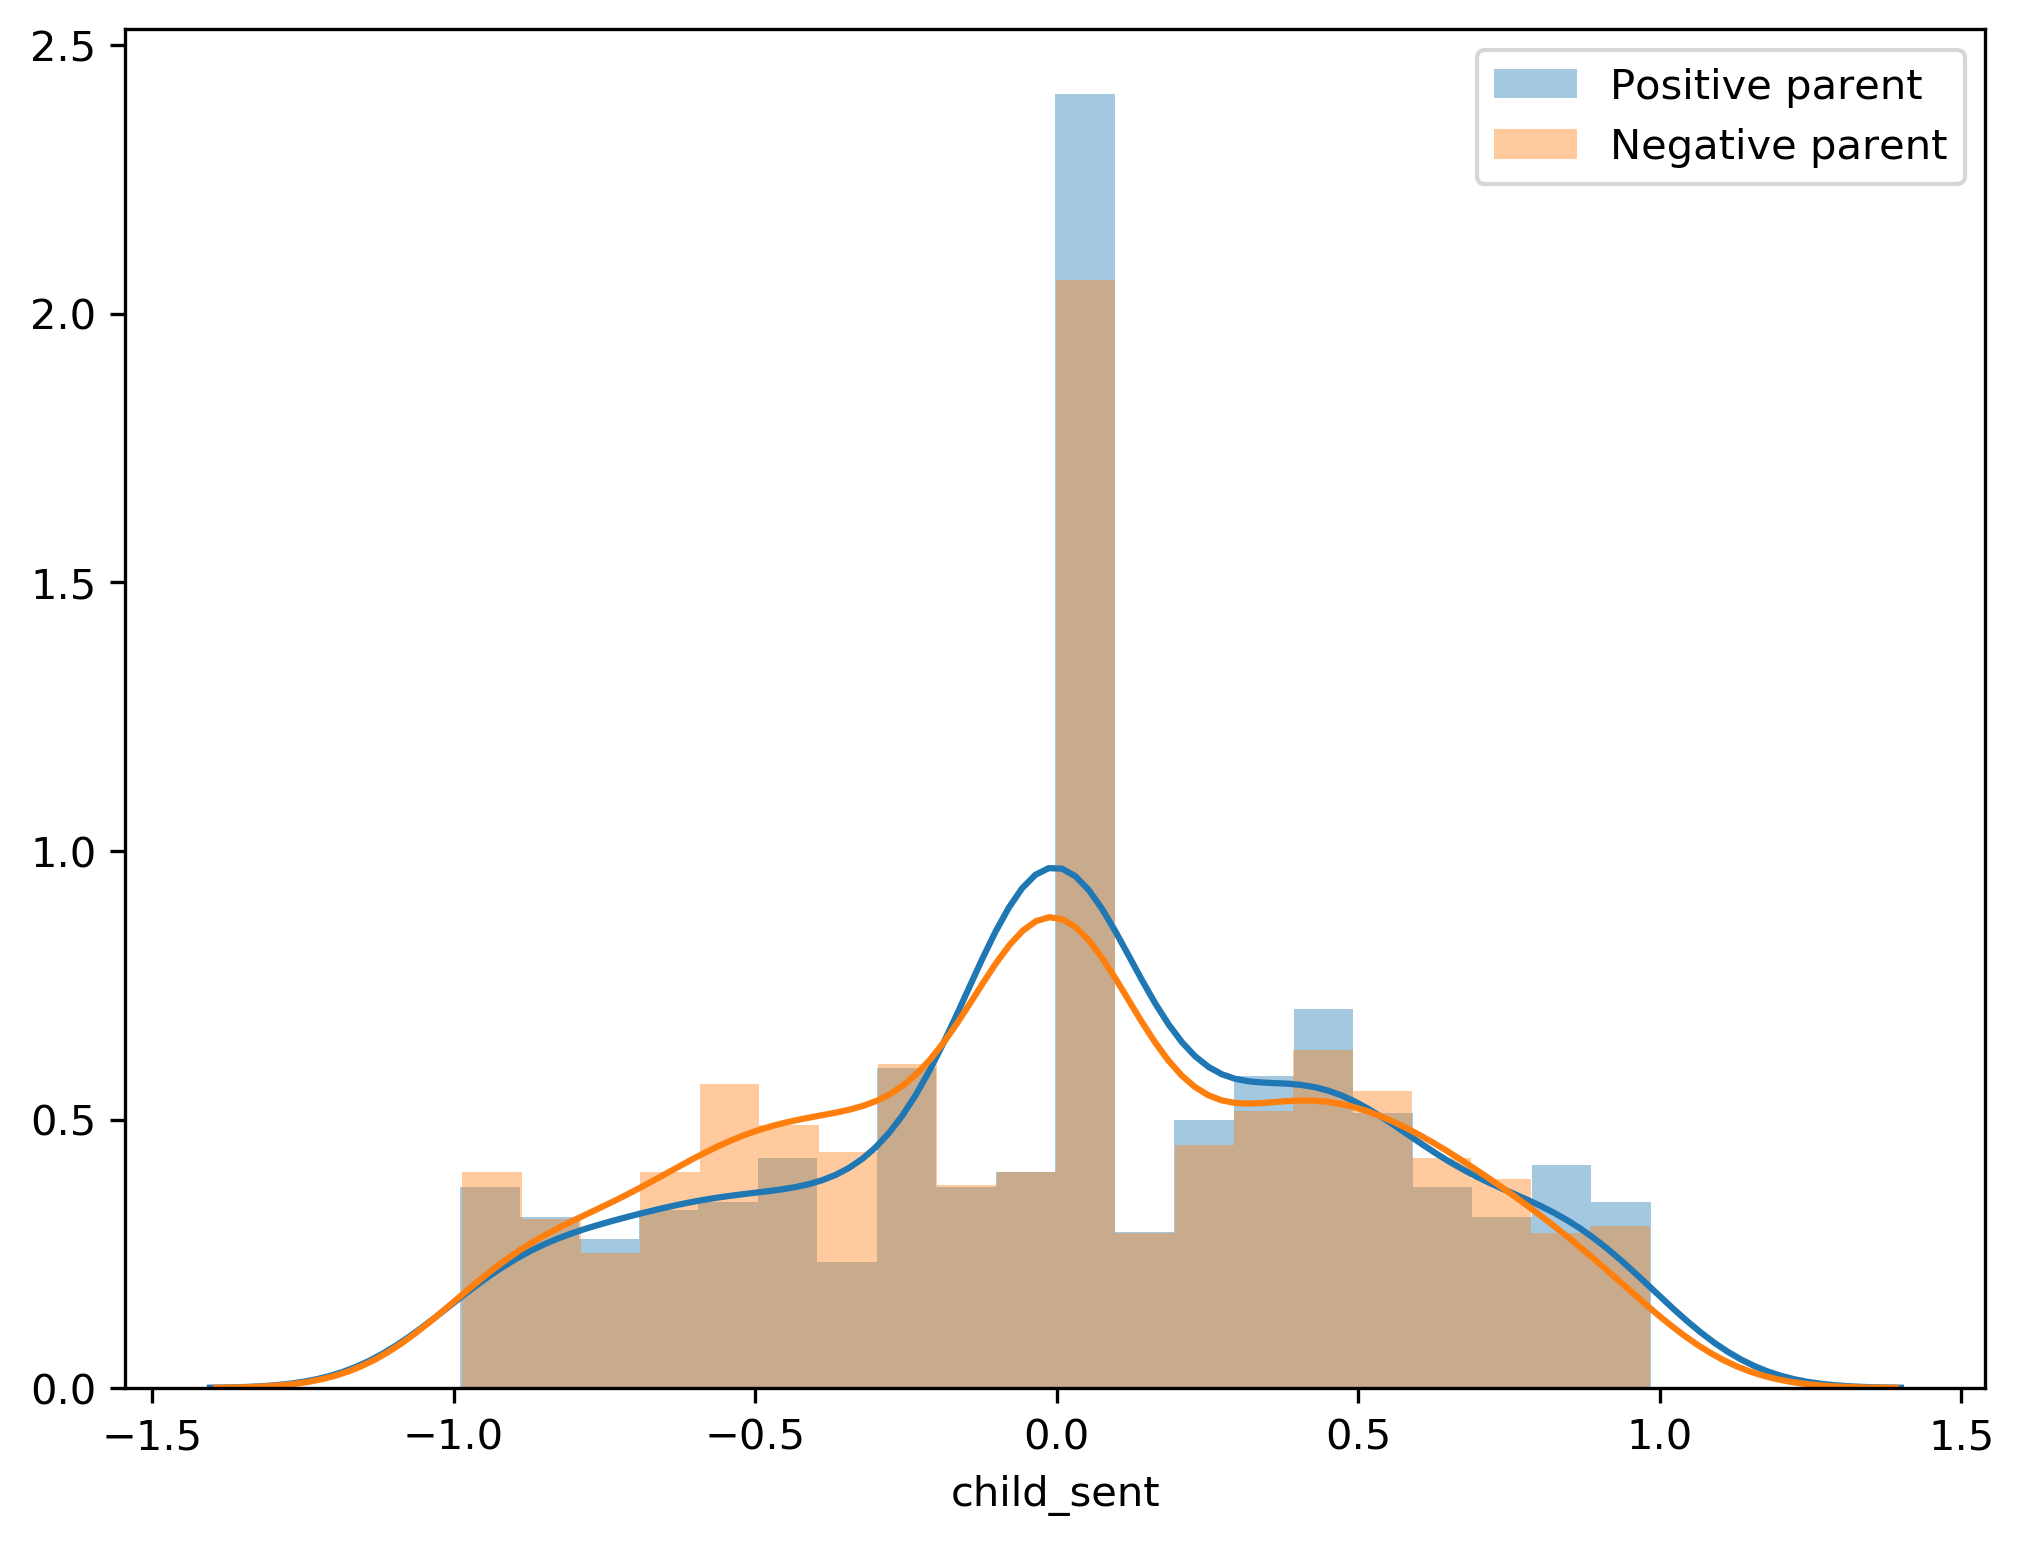

In [27]:
# Plot histograms for comment trees with positive vs negative root nodes
for df in ['full', 'neigh', 'depth', 'depth_worst']:
    figure(num=None, figsize=(8, 6), dpi=300)
    sns.distplot(df_sents[df].child_sent[df_sents[df].self_pos], label = 'Positive parent', bins = 20)
    sns.distplot(df_sents[df].child_sent[~df_sents[df].self_pos], label = 'Negative parent', bins = 20)
    plt.legend()
    plt.show()

In [28]:
# Compare means of subtrees with positive and negative root nodes
from scipy.stats import ttest_ind

for df in ['full', 'neigh', 'depth', 'depth_worst']:
    print('T test result for ' + df + ' method of analysis:')
    print(df_sents[df].child_sent[df_sents[df].self_pos].mean(), df_sents[df].child_sent[~df_sents[df].self_pos].mean())
    print(ttest_ind(df_sents[df].child_sent[df_sents[df].self_pos], df_sents[df].child_sent[~df_sents[df].self_pos]))

T test result for full method of analysis:
0.07114300786425935 0.010405764087709216
Ttest_indResult(statistic=4.360452690775402, pvalue=1.3509362799208241e-05)
T test result for neigh method of analysis:
0.08763039676206633 0.014166735652515895
Ttest_indResult(statistic=3.8338740223298564, pvalue=0.00012935336202042418)
T test result for depth method of analysis:
0.05353465043357037 -0.01334417422987468
Ttest_indResult(statistic=2.681835567932978, pvalue=0.007399379897404812)
T test result for depth_worst method of analysis:
0.03976812386156649 0.0008766398514851457
Ttest_indResult(statistic=1.5571296372818966, pvalue=0.11964544653980565)


In [29]:
print("Mean of positive depth-based children: ", df_sents['depth'].child_sent.mean())
print("Mean of negative depth-based children: ", df_sents['depth_worst'].child_sent.mean())

print(ttest_ind(df_sents['depth'].child_sent, df_sents['depth_worst'].child_sent))

Mean of positive depth-based children:  0.01807771258247563
Mean of negative depth-based children:  0.019362721861471862
Ttest_indResult(statistic=-0.07283570490965163, pvalue=0.9419415629055852)


In [30]:
# create a new post tree with all comments

post_ids = df_clean['link_id'].unique()

df_post= df_clean

g_post = nx.convert_matrix.from_pandas_edgelist(df_post, source = 'parent_id', target = 'id', create_using = nx.DiGraph)
print(len(g_post.nodes))

vader = SentimentIntensityAnalyzer()

for i, row in df_post.iterrows():
    if row.id in g_post.nodes:
        g_post.nodes[row.id]['sent'] = row.sentiment
        g_post.nodes[row.id]['score'] = row.score
        
for i, row in df_sub.iterrows():
    if row.id in g_post.nodes:
        g_post.nodes[row.id]['sent'] = vader.polarity_scores(row.title)['compound']
        g_post.nodes[row.id]['score'] = row.score

820657


In [31]:
branch_comment = np.array([[g_post.nodes[node]['score'], len(list(g_post.neighbors(node))), node in list(df_sub.id)] for node in g_post.nodes if 'score' in g_post.nodes[node]])

Text(0.5, 0, 'Score')

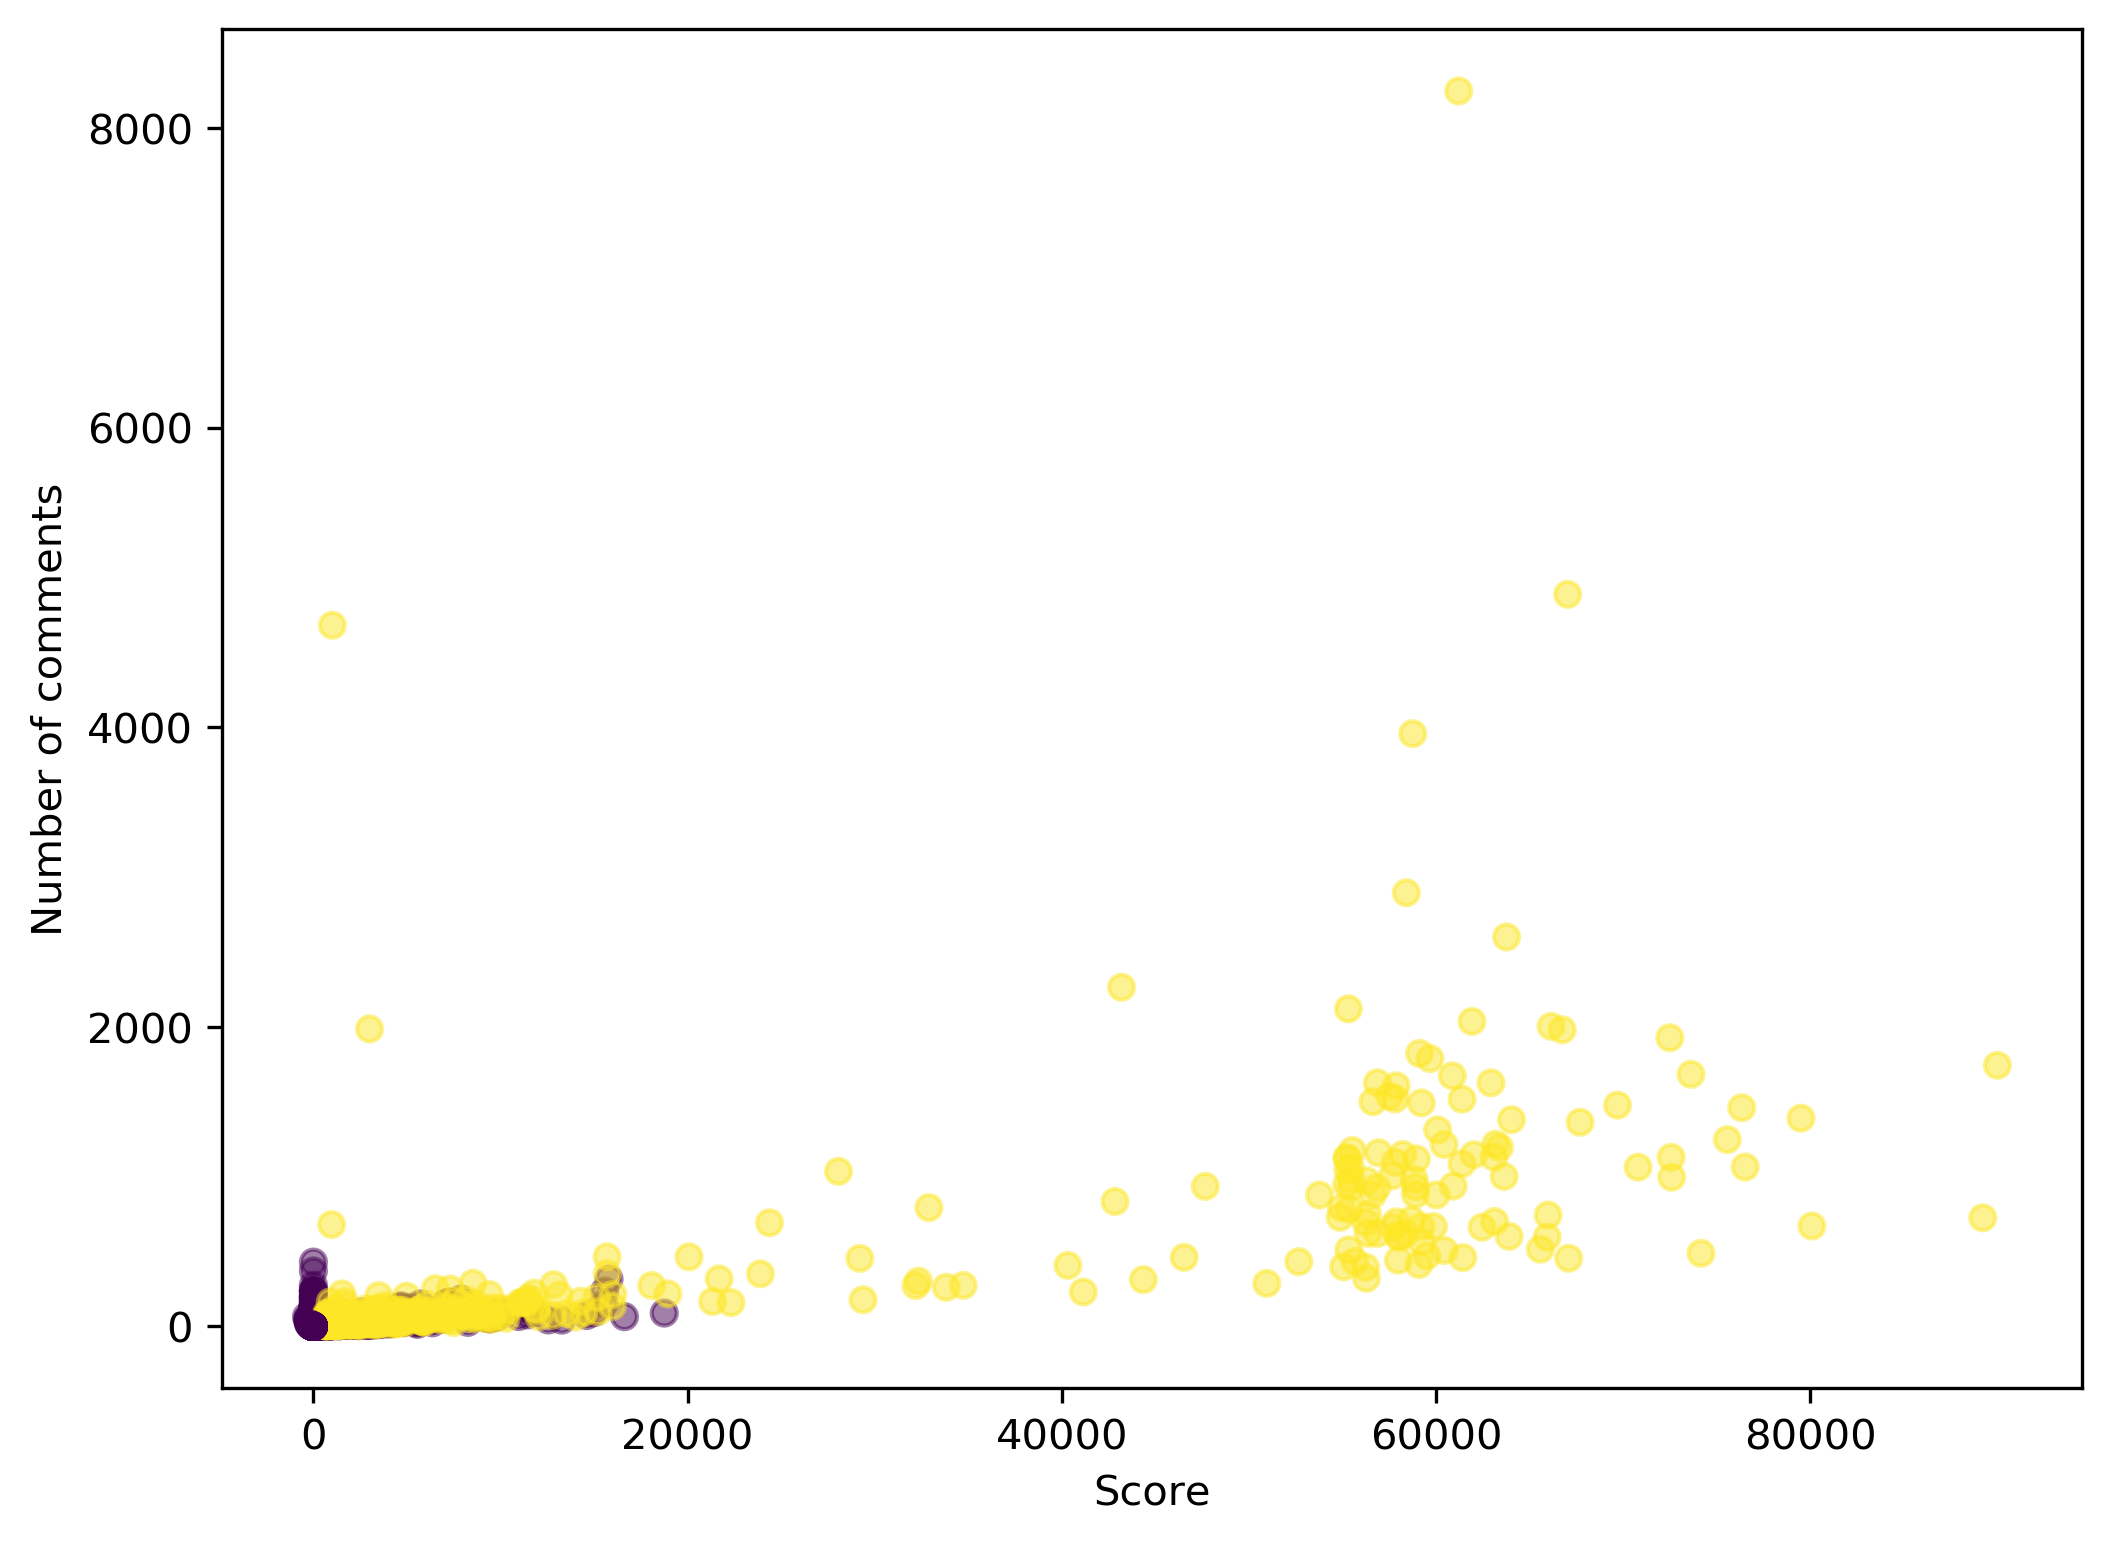

In [32]:
figure(num=None, figsize=(8, 6), dpi=300)

plt.scatter(branch_comment[:,0], branch_comment[:,1], c = branch_comment[:,2], alpha = 0.5)
plt.ylabel('Number of comments')
plt.xlabel('Score')

90003
18752


Text(0.5, 0, 'Score')

<Figure size 2400x1800 with 0 Axes>

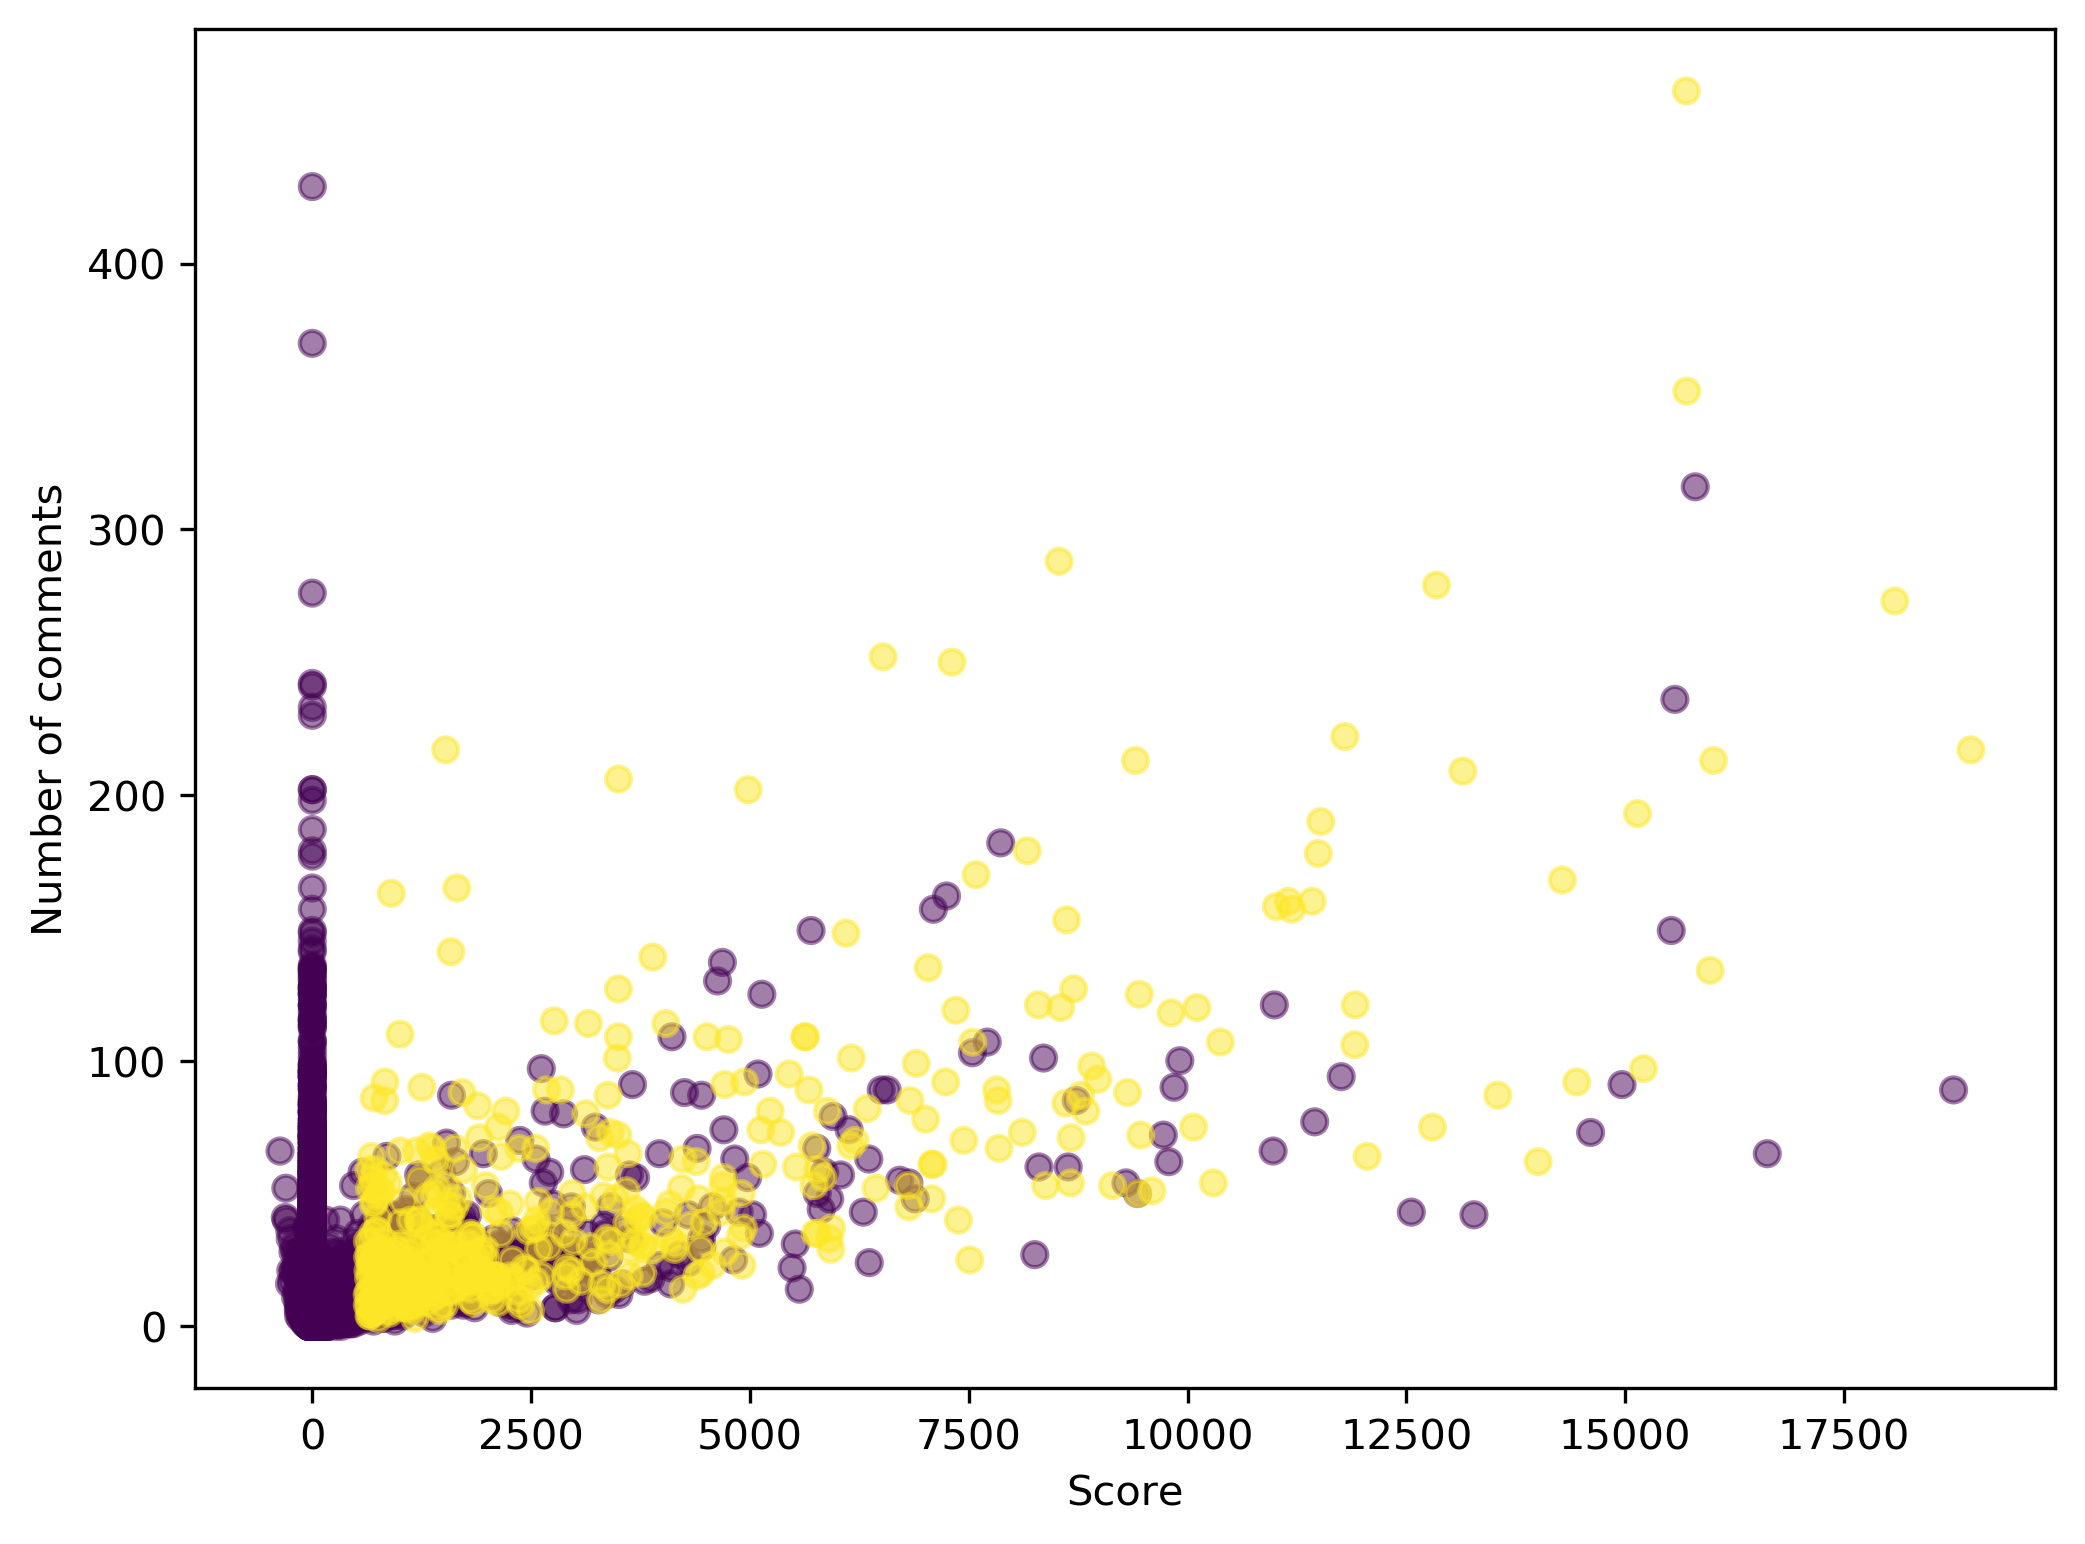

In [33]:
figure(num=None, figsize=(8, 6), dpi=300)

print(df_sub.score.max())
print(df_clean.score.max())
trunc = branch_comment[branch_comment[:,0] < 19000]
trunc = trunc[trunc[:,1] < 600]

figure(num=None, figsize=(8, 6), dpi=300)

plt.scatter(trunc[:,0], trunc[:,1], c = trunc[:,2], alpha = 0.5)
plt.ylabel('Number of comments')
plt.xlabel('Score')